In [1]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns',None)
plt.style.use('fivethirtyeight')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import scipy.stats as stats
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [2]:
data_lead_1 = pd.read_csv('Leads.csv') # Taking the Leads data and loading into dataframe

In [3]:
data_lead_1.info()

# from initial inferences it can be noted
# there are approximately 37 columns and 9240 rows with some rows having data missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [4]:
data_lead_1['Converted'].value_counts()

0    5679
1    3561
Name: Converted, dtype: int64

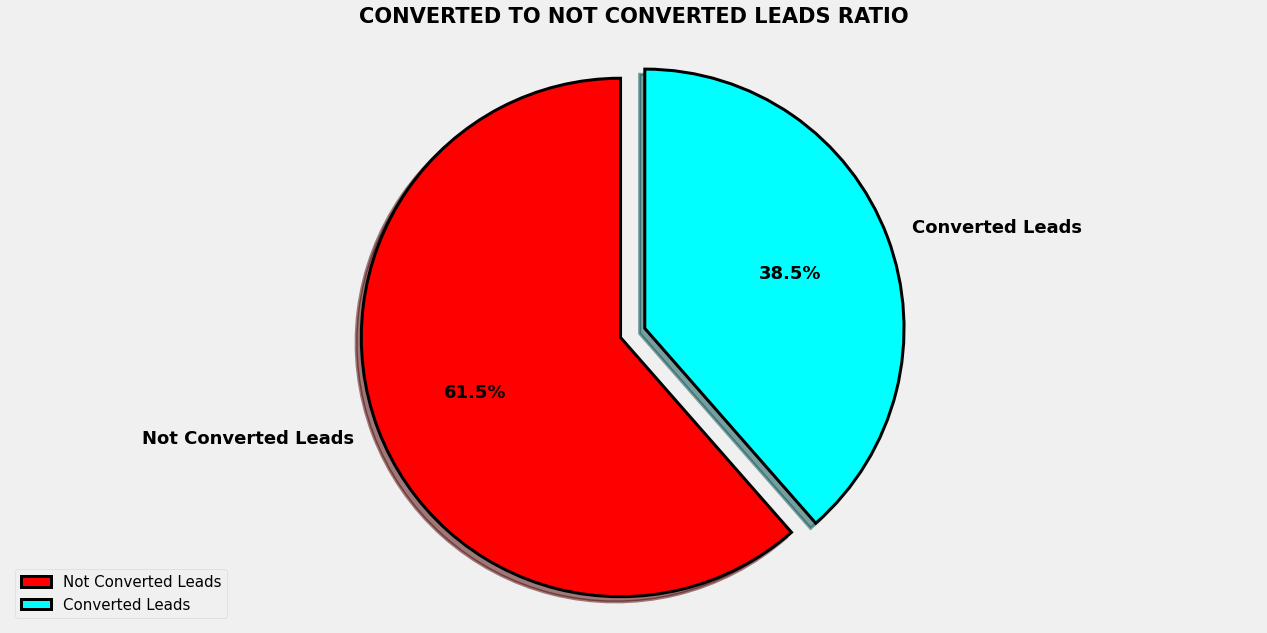

'From the initial graph it can be seen that the data is imbalanced where the percentage of converted leads\nis almost double of the percentage of non converted leads'

In [5]:
x = data_lead_1.loc[:,'Converted'].value_counts() # Taking the count as both 0 and 1 for converted and not conve
labels = ['Not Converted Leads','Converted Leads']

plt.figure(figsize=(20,10))
explode = [0.0,0.1] # we will explode our pie chart for the highest and lowest value in our group
colors = ['red','cyan']
plt.pie(x,labels=labels,startangle=90,explode=explode,colors = colors,autopct = "%1.1f%%",shadow = True
       ,labeldistance=1.1,textprops = {'fontweight':'bold','fontsize':18},
        wedgeprops={'linewidth':3,'edgecolor':"k"}) # All the parameters of the above are directly
#refered from matplotlib documentation

plt.legend(loc = 3,fontsize = 15)
plt.title("CONVERTED TO NOT CONVERTED LEADS RATIO",fontweight = "bold",fontsize = 21,pad = 20)
plt.axis('equal')
plt.show()

'''From the initial graph it can be seen that the data is imbalanced where the percentage of converted leads
is almost double of the percentage of non converted leads'''


In [6]:
# Lets write a forloop to see which are all the variables having null values

dictionary_leads_null_values = {} # creating a dictionary which will be later converting into dataframe

for feature in data_lead_1.columns:
    if data_lead_1[feature].isnull().sum() > 0:
        
        dictionary_leads_null_values[feature] = (data_lead_1[feature].isnull().sum()/len(data_lead_1)) * 100
        


In [7]:
data_null_values=pd.DataFrame.from_dict(dictionary_leads_null_values,orient='index')

In [8]:
data_null_values.columns = ['null values']

In [9]:
print(data_null_values)
print(len(data_null_values))

# In total there are 17 colums which are having null values

# As a limit for now we will be converting the null values for the columns which are having the null percentage less that 30

data_impute = data_null_values[data_null_values['null values'] <= 30.0]

                                               null values
Lead Source                                       0.389610
TotalVisits                                       1.482684
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   15.562771
How did you hear about X Education               23.885281
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Tags                                             36.287879
Lead Quality                                     51.590909
Lead Profile                                     29.318182
City                                             15.367965
Asymmetrique Activity Index                      45.649351
Asymmetrique Profile Index                       45.649351
Asymmetrique Activity Score                      45.6493

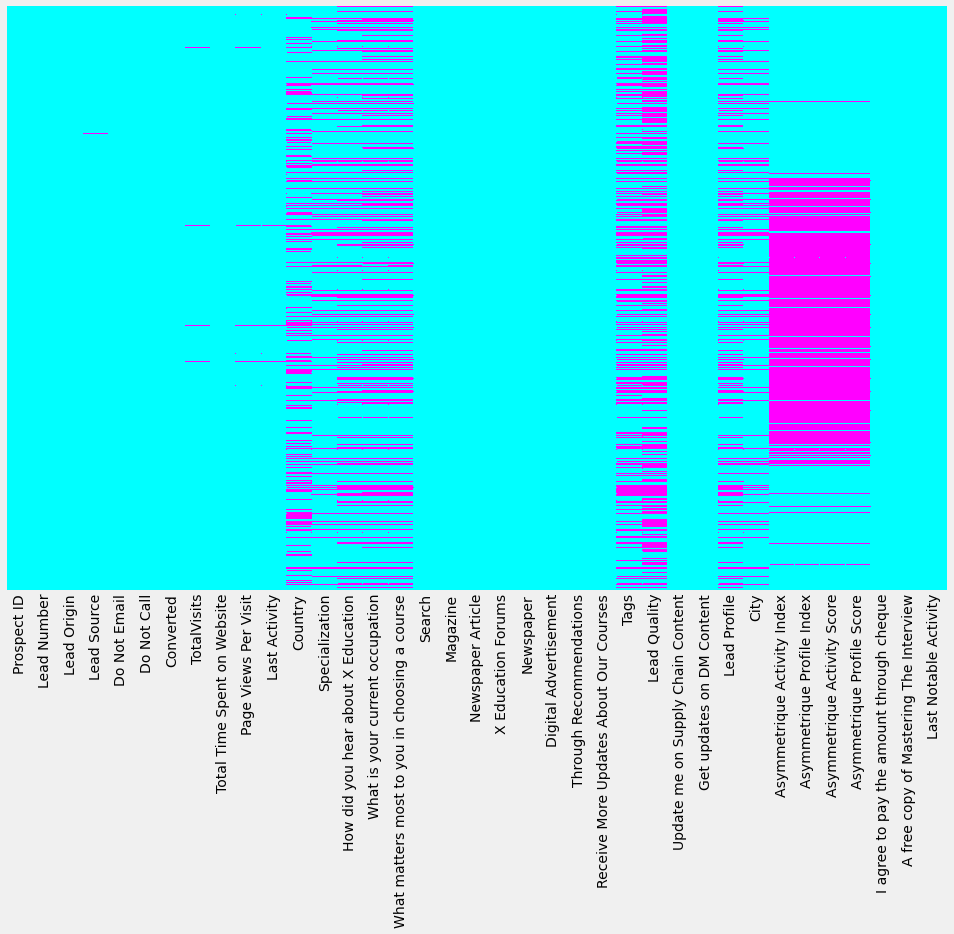

' If observed carefully null values are showing sort of a pattern here\n.We can observe that many of the null values are observed in the data related to Questionary\nlike filling the country , Questions about current occupation etc. These might also be non man\ndatory fields present in the field filled by the users'

In [10]:
fig = plt.figure(figsize=(15,10))

sns.heatmap(data_lead_1.isnull(),yticklabels=False,cbar=False,cmap='cool')
sns.color_palette("magma")
plt.show()

''' If observed carefully null values are showing sort of a pattern here
.We can observe that many of the null values are observed in the data related to Questionary
like filling the country , Questions about current occupation etc. These might also be non man
datory fields present in the field filled by the users'''

In [11]:
len(data_impute) #so there are 11 columns on which  I can do imputation on 


11

In [12]:
list_imputation = data_impute.index.to_list()

In [13]:
list_imputation # below is the total list of columns on which we will be performing the imputations

['Lead Source',
 'TotalVisits',
 'Page Views Per Visit',
 'Last Activity',
 'Country',
 'Specialization',
 'How did you hear about X Education',
 'What is your current occupation',
 'What matters most to you in choosing a course',
 'Lead Profile',
 'City']

In [14]:
# In our dataset there are columns which are having null values in the form of select
# This can happen when a default was kept as select and there was no user activity on that
# These values needs to be treated as null values and percentage of null values should be noted for the same


list_select_null_values = []


'''We will be creating an empty list in which we will be storing the column names having Select 
as null values'''

for feature in data_lead_1.columns:
    if data_lead_1[feature].dtype == 'O':

        if data_lead_1[feature].str.contains('Select').sum() > 0:
            list_select_null_values.append(feature)
            
        elif data_lead_1[feature].str.contains('select').sum() > 0:
            list_select_null_values.append(feature)

In [15]:
list_select_null_values # Below 4 features are there having null values

['Specialization',
 'How did you hear about X Education',
 'Lead Profile',
 'City']

In [16]:
# Lets replace all these features select as nan

def impute_nan(x):
    
    if x == 'Select':
        return np.nan
    else:
        return x

In [17]:
data_lead_2 = data_lead_1.copy() # creating an initial shallow copy

In [18]:
for feature in list_select_null_values:
    data_lead_2[feature] = data_lead_2[feature].apply(impute_nan)

In [19]:
# lets check if all our Select values have been replaced correctly
for feature in list_select_null_values:
    
    if  data_lead_2[feature].str.contains('Select').sum() > 0:
        print('True')
        break
else:
    print('False')

False


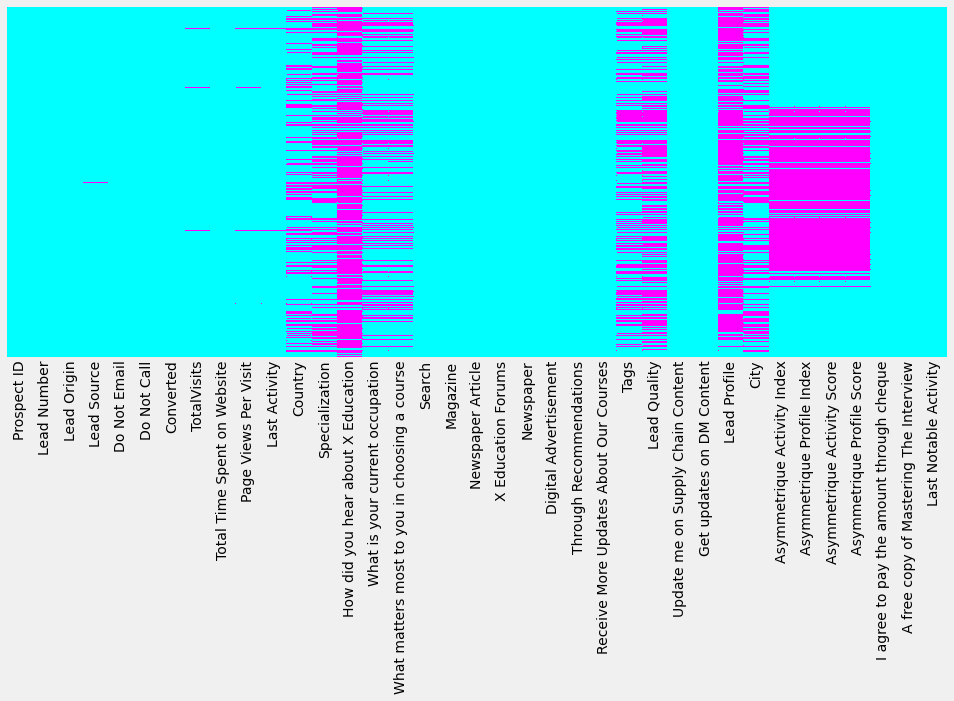

In [20]:
fig = plt.figure(figsize=(15,6))

sns.heatmap(data_lead_2.isnull(),yticklabels=False,cbar=False,cmap='cool')

# The column specialization , Education after filling the select with nan are showing a much denser null
# values and are close to around 40-45% range

In [21]:
'''Before going for imputations lets do the analysis with our in hand data'''
# Lead Number and Prospect ID are the primary key data and is mostly used for keeping index so it is not
#useful for our analysis we will be dropping these values later on during our analysis




data_grouped = data_lead_2.groupby('Lead Origin')['Converted'].mean().reset_index()

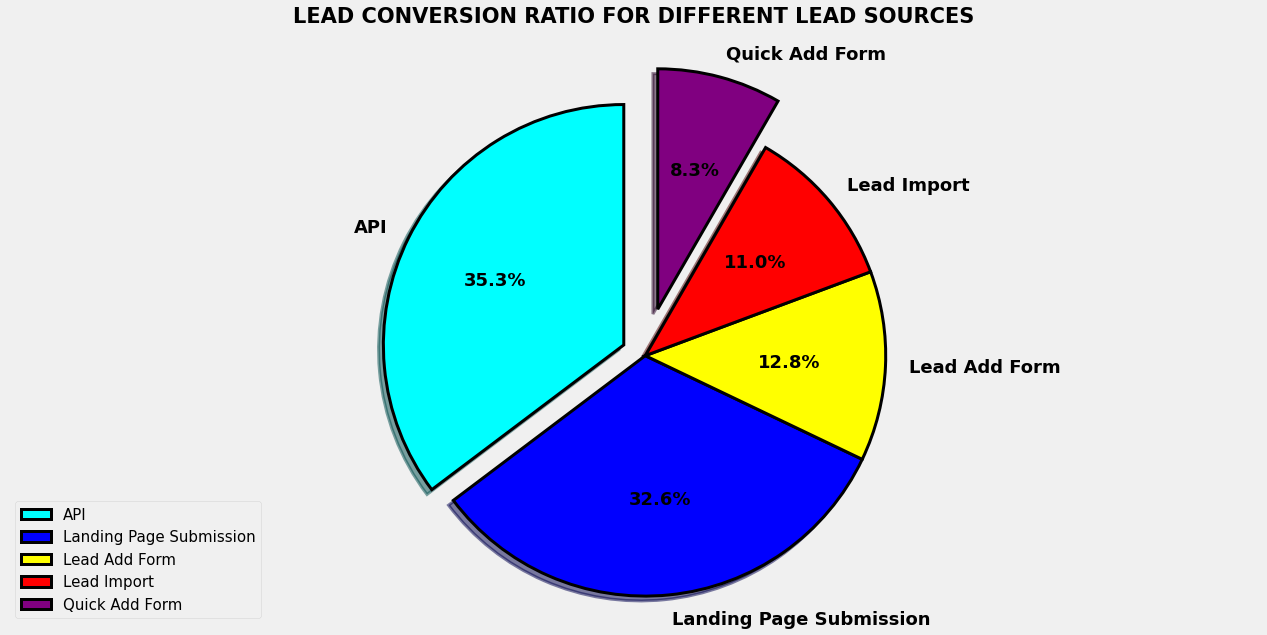

' From the below inspection we can see that the highest conversion of the lead can be seen \nwith respect to API and the lowest can be seen in the quick add form'

In [22]:
data_grouped

x1 = data_grouped['Lead Origin'].to_list() # we will be converting the same 

x2 = data_grouped.iloc[:,1].sort_values(ascending = False)

plt.figure(figsize=(20,10))
explode = [0.1,0.0,0.0,0.0,0.2] # we will explode our pie chart for the highest and lowest value in our group
colors = ['cyan','blue','yellow','red','purple']
plt.pie(x2,labels=x1,startangle=90,explode=explode,colors = colors,autopct = "%1.1f%%",shadow = True
       ,labeldistance=1.1,textprops = {'fontweight':'bold','fontsize':18},
        wedgeprops={'linewidth':3,'edgecolor':"k"}) # All the parameters of the above are directly
#refered from matplotlib documentation

plt.legend(loc = 3,fontsize = 15)
plt.title("LEAD CONVERSION RATIO FOR DIFFERENT LEAD SOURCES",fontweight = "bold",fontsize = 21,pad = 20)
plt.axis('equal')
plt.style.use('fivethirtyeight')
plt.show()


''' From the below inspection we can see that the highest conversion of the lead can be seen 
with respect to API and the lowest can be seen in the quick add form'''





In [23]:
'''In the feature lead source we have Google repeating 2 times due to different string validations'''

data_lead_2['Lead Source'].replace({'google':'Google'},inplace=True)

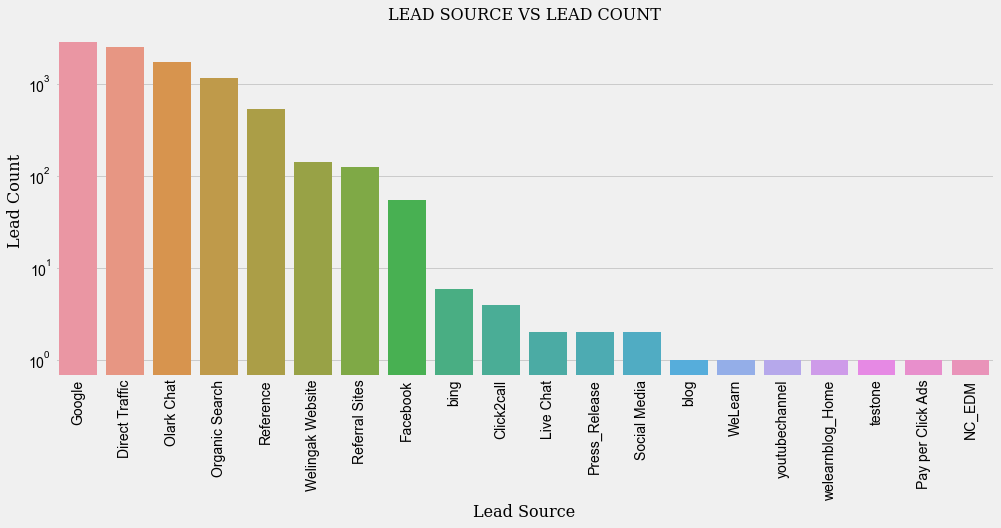

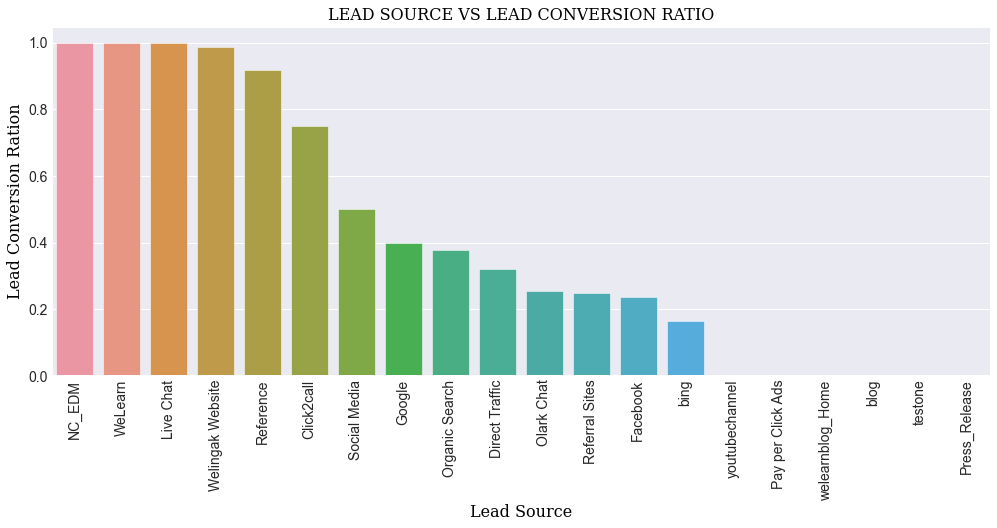

'Hereafter to increase the conversion resources should be invested more on NC_EDM source followed by \nthe site we learn since these two are origination least amount of leads but are showing the highest lead\nconversion'

In [24]:
# Lets take a look at how many leads are getting generated from each Lead source

# we will be creating the font dictionary which we will be using hereafter for plotting
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize = (15,6))
ax = sns.countplot(x = 'Lead Source' , data=data_lead_2 , order=data_lead_2['Lead Source'].value_counts().index)
'''We will be using ax as a constructor this will help us to use plt functionalities further
to manipulate the seaborn chart and have more control over the axis and other parameters'''
plt.xticks(rotation = 90)
plt.yscale('log') # Using log scale since there is a huge gap in the number of leads generated from each source
sns.set_style('darkgrid')
sns.color_palette("pastel")
plt.xlabel('Lead Source' , fontdict=font)
plt.ylabel('Lead Count',fontdict=font)
plt.title('LEAD SOURCE VS LEAD COUNT' , fontdict=font)
plt.show()

'''Majority of the leads are generated from Google and Direct Trafic where a marginal amount of leads
can be seen with respect to the WeLearn and other platforms'''


fig = plt.figure(figsize = (15,6))
data_grouped_lead_conversion = data_lead_2.groupby('Lead Source')['Converted'].mean().sort_values(ascending = False).reset_index()

ax = sns.barplot(x = data_grouped_lead_conversion['Lead Source'] , y = data_grouped_lead_conversion.Converted)
plt.xticks(rotation = 90) # Using log scale since there is a huge gap in the number of leads generated from each source
sns.set_style('darkgrid')
sns.color_palette("pastel")
plt.xlabel('Lead Source' , fontdict=font)
plt.ylabel('Lead Conversion Ration',fontdict=font)
plt.title('LEAD SOURCE VS LEAD CONVERSION RATIO' , fontdict=font)
plt.show()

'''Highest Conversion can be seen from NC_EDM and no conversions can be seen with respect to you tube channel
sources , blog pages , pay per click ads etc'''

'''Hereafter to increase the conversion resources should be invested more on NC_EDM source followed by 
the site we learn since these two are origination least amount of leads but are showing the highest lead
conversion'''




In [25]:

'''Inspecting the country data frame , something which is strikingly noticeable is that countries after
Qatar showing single digits queries which could be due to the reason that the company is still 
settling in those countries and thus is not getting leads as much compared to other countries.
To reduce the no of categories in this column we will reduce all the countries after qatar into one 
single category of columns others and herafter do the further analysing of the column country'''
data_lead_2.Country.value_counts()

data_selected_countries = data_lead_2.Country.value_counts().index[0:8] # taking the countries till qatar

data_lead_2.Country = np.where(data_lead_2.Country.isin(data_selected_countries),data_lead_2.Country,'Other') 






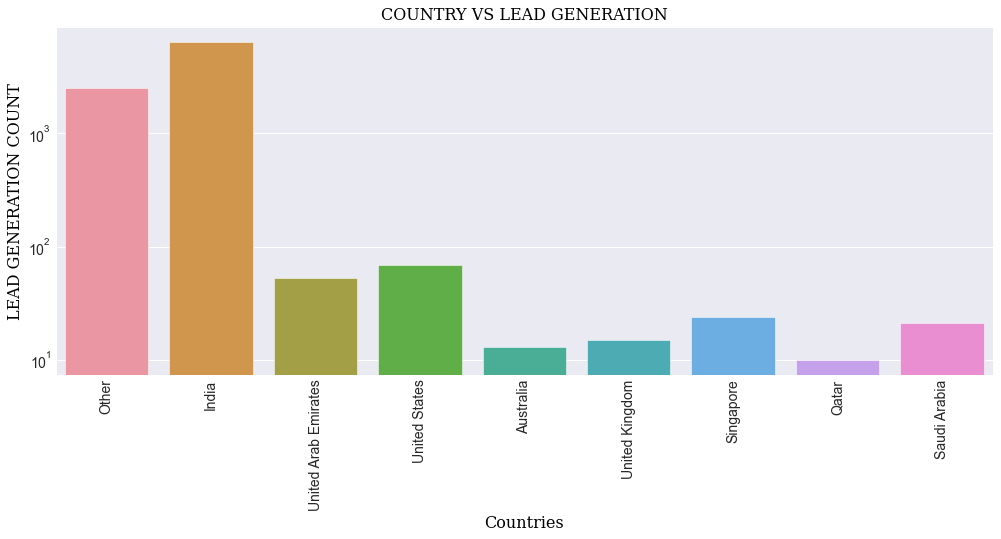

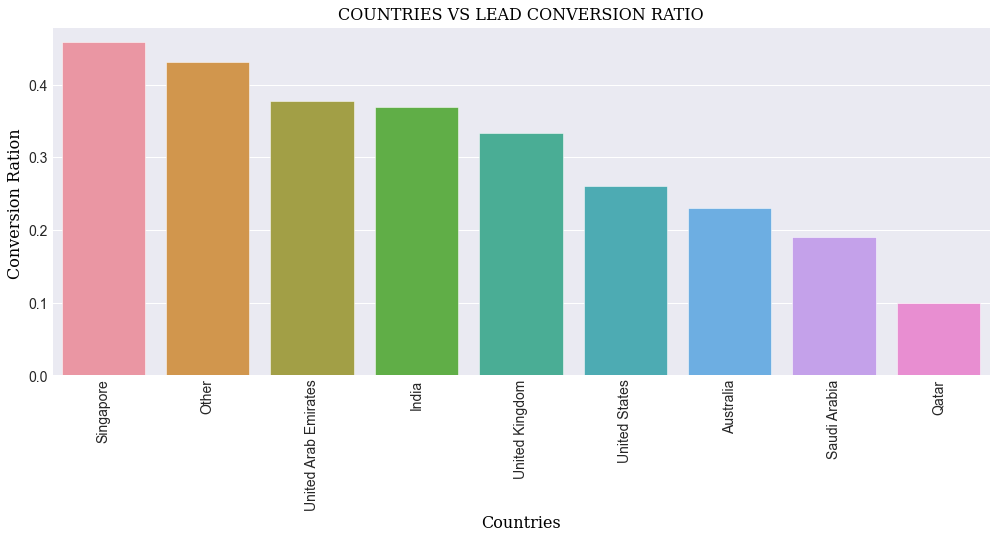

'Singapore is showing the highest lead conversion ratio among all the countries followed closely \nby UAE and India . where there is almost a probability of close to 50% of getting the lead converted.\nThus Singapore can be termed as a potential city for expanding the X- EDUCATION business in great\nproportion.'

In [26]:
fig = plt.figure(figsize = (15,6))

ax = sns.countplot(data_lead_2.Country)

plt.xticks(rotation = 90) # Using log scale since there is a huge gap in the number of leads generated from each source
sns.set_style('darkgrid')
sns.color_palette("pastel")
plt.yscale('log')
plt.xlabel('Countries' , fontdict=font)
plt.ylabel('LEAD GENERATION COUNT',fontdict=font)
plt.title('COUNTRY VS LEAD GENERATION' , fontdict=font)
plt.show()

'''Highest number of leads is generated by India , Almost close to 31 countries are constituting together
for second highest number of leads , United States can be considered second here as an indvidual 
country. Again from our initial inspection it can be seen that majority of the leads generated is from 
India and market is slowly picking up in other countires'''

data_lead_country = data_lead_2.groupby('Country')['Converted'].mean().sort_values(ascending = False).reset_index()

fig = plt.figure(figsize = (15,6))
ax = sns.barplot(data_lead_country.Country,data_lead_country.Converted)
plt.xlabel('Countries' , fontdict=font)
plt.ylabel('Conversion Ration ',fontdict=font)
plt.title('COUNTRIES VS LEAD CONVERSION RATIO' , fontdict=font)
plt.xticks(rotation = 90)
plt.show()

'''Singapore is showing the highest lead conversion ratio among all the countries followed closely 
by UAE and India . where there is almost a probability of close to 50% of getting the lead converted.
Thus Singapore can be termed as a potential city for expanding the X- EDUCATION business in great
proportion.'''



In [27]:
leads_data = data_lead_2.loc[:,'Search':'Receive More Updates About Our Courses']

In [28]:
leads_data = leads_data.apply(pd.Series.value_counts) # pivoting the columns

In [29]:
leads_data.reset_index()

'''From below it can be seen that columns like Magazine , Recieve More Update our Courses are showing Nan
value realated to lead conversion 1. Magazine is one of the adversiments ticks , since there is no 
positive indications here about the lead conversion related to Magazine , we can say that no resources
should be used in marketing advertisement'''

,index,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses
0,No,9226,9240.0,9238,9239,9239,9236,9233,9240.0
1,Yes,14,NaN,2,1,1,4,7,NaN


'From below informatics it can be infered that the Profile score is directly related to the chances\nof conversion , that is higher profile score is definitely a good predictor of conversion'

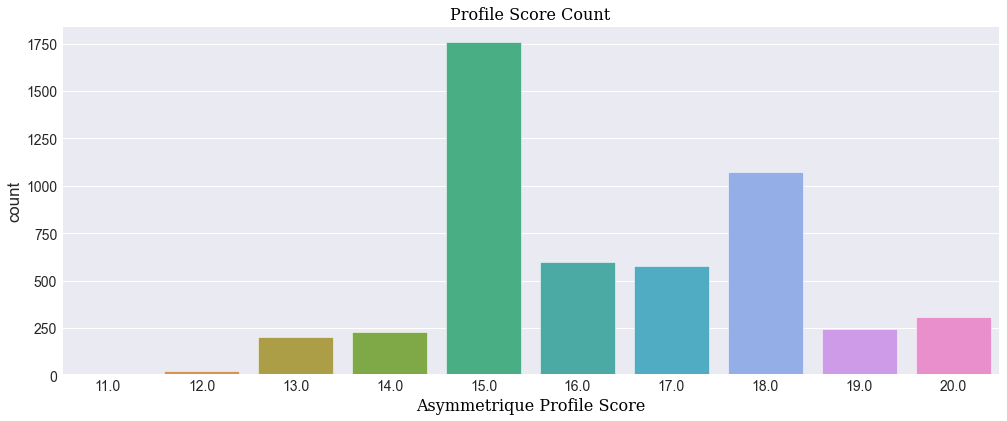

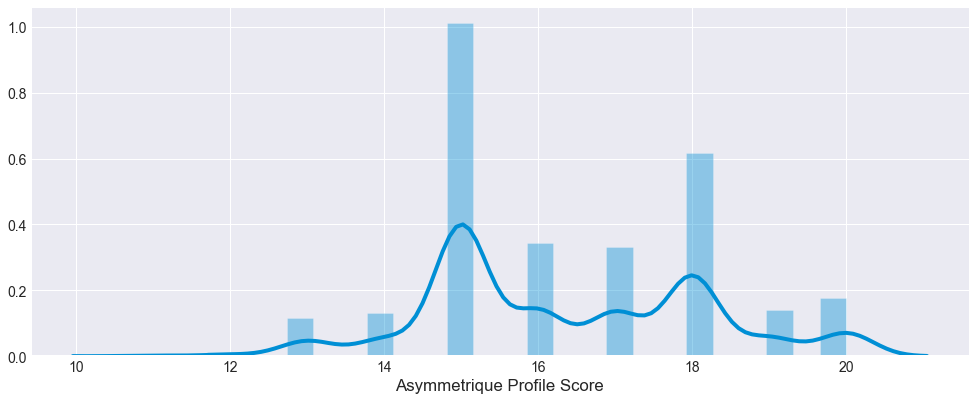

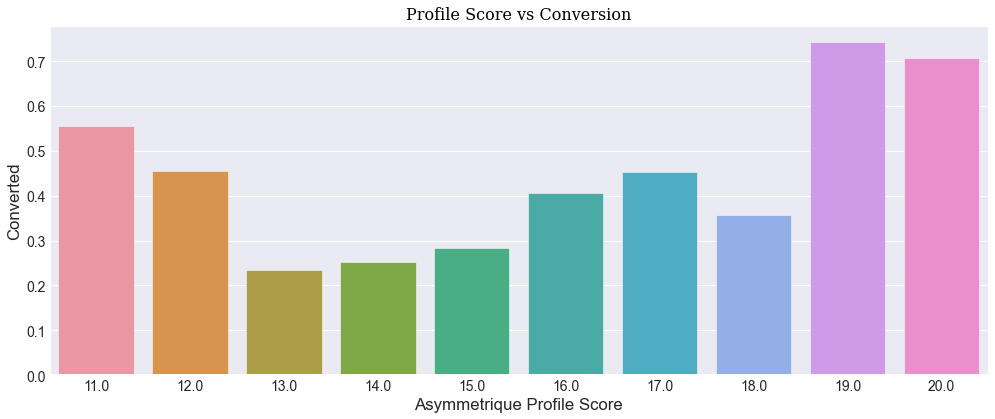

In [32]:
data_lead_2

'''In our Dataset there are certain columns Asymmetrique which is basically the score and profile indexing
of each of the customer, Activity socre and Profile score is possible given to access the profile
for their background. This is important to our case the reason being that a profile and activity score 
are one of the very few numerical features which quantify a profile'''


fig = plt.figure(figsize=(15,6))

ax = sns.countplot(data_lead_2['Asymmetrique Profile Score'])
plt.title('Profile Score Count',fontdict=font)
plt.xlabel('Asymmetrique Profile Score',fontdict=font)

fig = plt.figure(figsize = (15,6))
ax = sns.distplot(data_lead_2['Asymmetrique Profile Score'])

'''From the Below inspection it can be seen that majority of the leads are getting a profile
score of around 15  followed by 18 being the second highest'''

'''Lets look at the conversion ratio score wise here to see how the scores affecting the lead
conversion chances'''


fig = plt.figure(figsize = (15,6))

data_grouped_Asymmetric = data_lead_2.groupby('Asymmetrique Profile Score')['Converted'].mean().reset_index()

ax = sns.barplot(data_grouped_Asymmetric['Asymmetrique Profile Score'] , data_grouped_Asymmetric.Converted)

plt.title('Profile Score vs Conversion',fontdict=font)


'''From below informatics it can be infered that the Profile score is directly related to the chances
of conversion , that is higher profile score is definitely a good predictor of conversion'''





In [33]:
data_lead_2.drop(['Prospect ID','Lead Number'] , axis = 1 , inplace=True)

'''Prospect ID and Lead Number both are unique identifiers are does not help in generalising the variables
and hence are being dropped'''

'Prospect ID and Lead Number both are unique identifiers are does not help in generalising the variables\nand hence are being dropped'

In [34]:
data_lead_2

# Lets go ahead and draw the bar chart and plot for all the Asymmetric columns excluding score


list_asymmetrique = data_lead_2.loc[:,'Asymmetrique Activity Index':'Asymmetrique Profile Score'].columns.to_list()

In [35]:
list_asymmetrique.remove('Asymmetrique Profile Score')

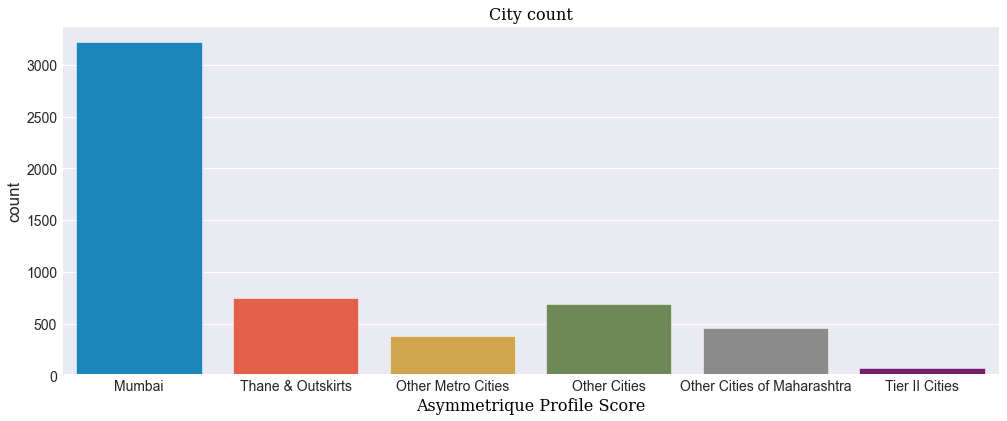

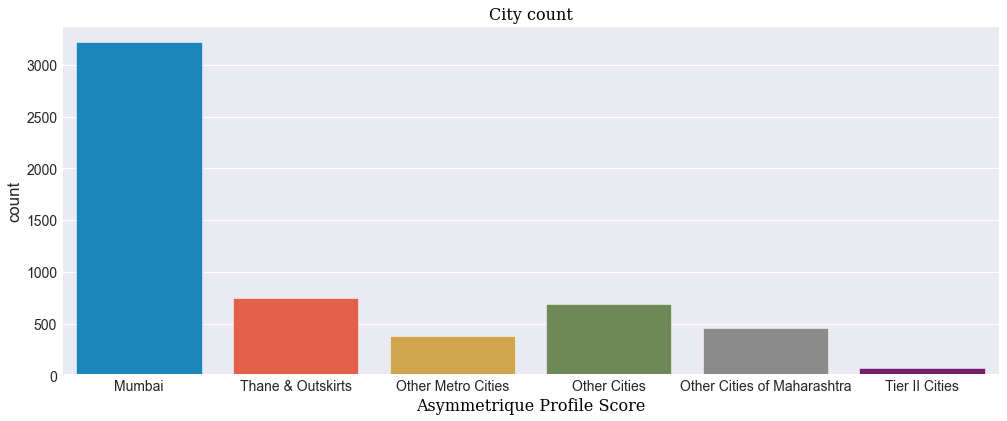

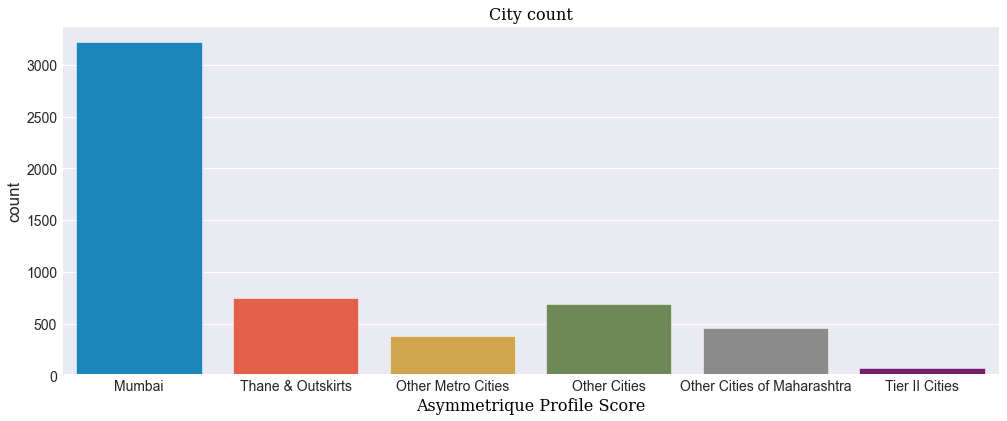

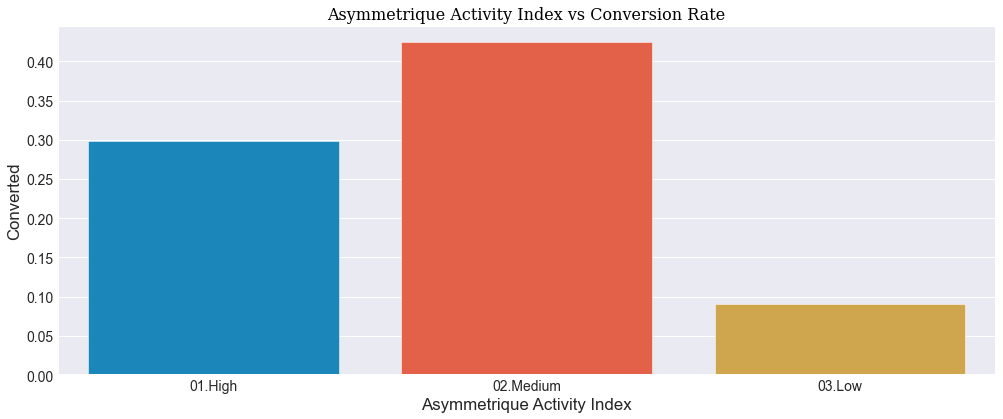

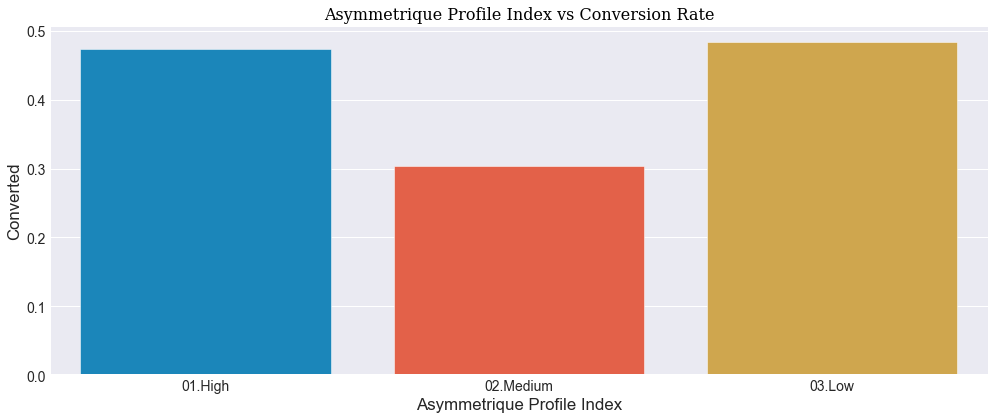

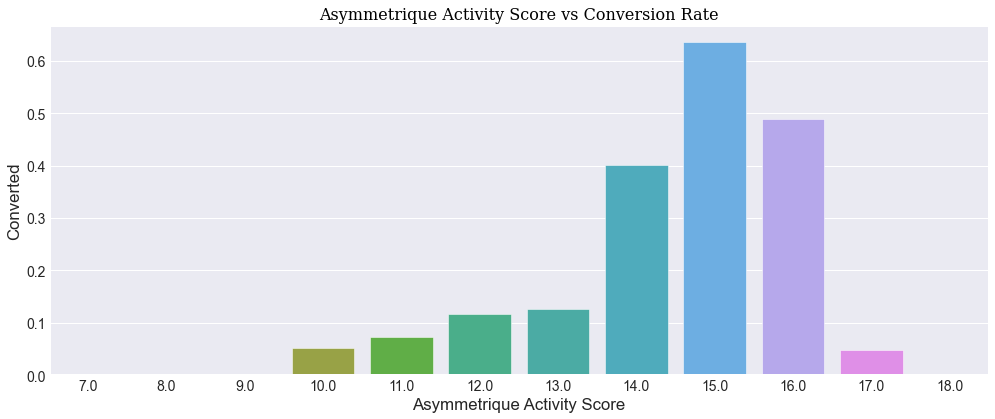

In [36]:
for features in list_asymmetrique:
    
    
    fig = plt.figure(figsize=(15,6))

    ax = sns.countplot(data_lead_2[feature])
    plt.title('{} count'.format(feature),fontdict=font)
    plt.xlabel('Asymmetrique Profile Score',fontdict=font)
    


def feature_groupby_plot(feature):# creating a seprate group by function for plotting where we will be passing
    
    data_copy = data_lead_2.copy()
    
    data_grouped1 = data_copy.groupby(feature)['Converted'].mean().reset_index()
    
    fig = plt.figure(figsize=(15,6))
    
    ax = sns.barplot(data_grouped1[feature],data_grouped1['Converted'])
    
    plt.title('{} vs Conversion Rate'.format(feature),fontdict=font)
    
    plt.show()

    
'''Calling the function for each of the variable'''
for features in list_asymmetrique:
    
    feature_groupby_plot(features)


    

# EDA INFERENCES PART 1

1. Our Dataset is imbalanced where we have a 60% to 40% ratio between leads getting converted and not getting converted
2. We have Lead Origins like API , forms etc where highest amount of conversion is shown by the leads originating from API
3. Next we analysed the Lead Source vs Lead Conversion ratio ,  where it can be seen that NC_EDM source is a good source of quality leads which is showing the highest amount of lead conversions compared to other lead sources despite the fact that there are very low numbers of leads generating from that platform , an increase in the lead generation from that particular platform can lead to more growth
4. From the countries Analysis , it can be seen that major market for revenue is India where majority of the leads are generated from India followed by UK and US. One of the most promising and upcoming markets is in Singapore where it can be clearly seen that it is showing good quality leads and a more intereseted population . An expansion in this market can lead to a definite growth.
5. We have metrics such as Profile score and Activity index which coming from the analysis is looking one of the most prominent features among all the features in the dataset for the prediction of convertable and non convertable leads , also City score wise Mumbai is looking as the most revenue earning city among all the operatable cities currently present.

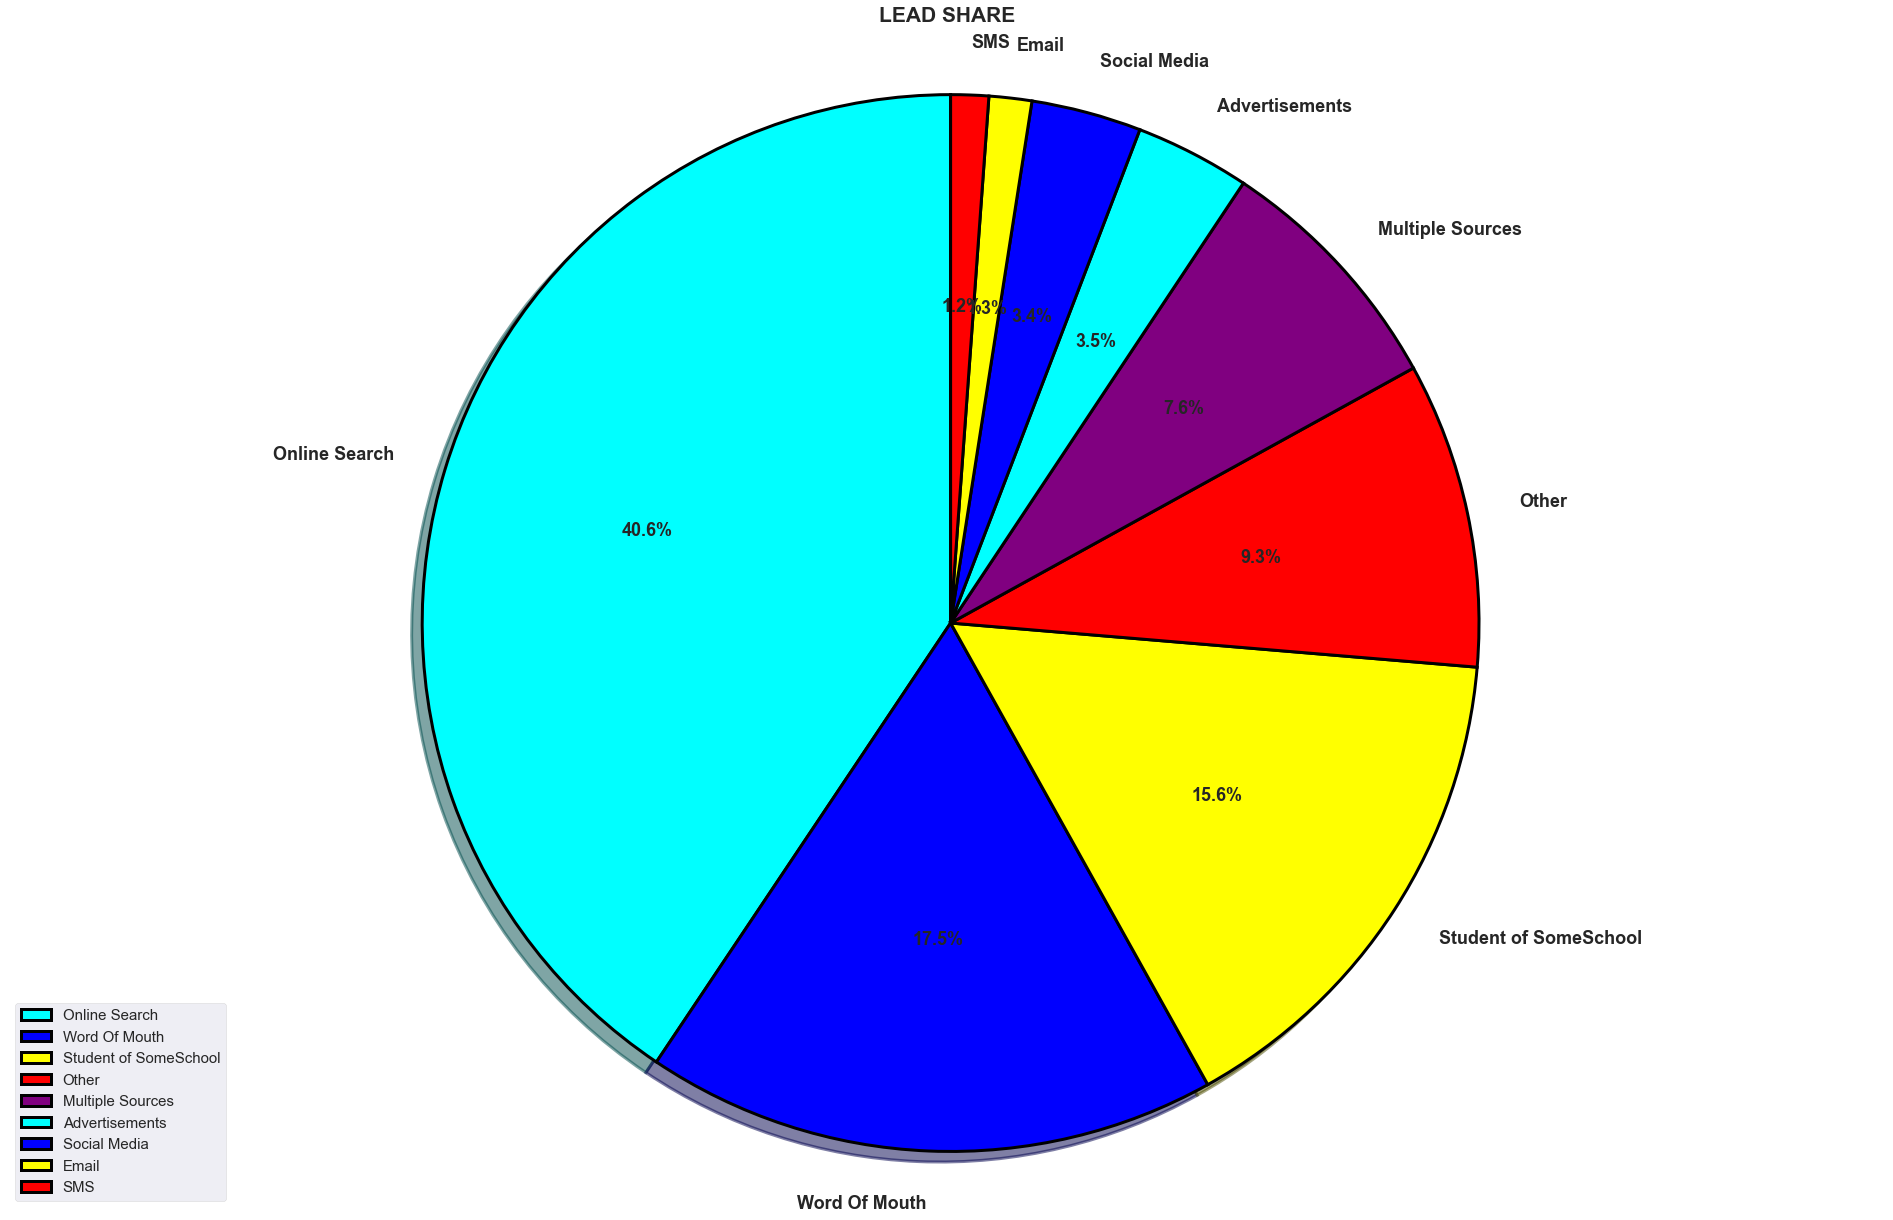

In [37]:
x1 = data_lead_2['How did you hear about X Education'].value_counts().to_list()
x2 = pd.DataFrame(data_lead_2['How did you hear about X Education'].value_counts().reset_index())
x3 = x2['index'].to_list() # Taking the list 


plt.figure(figsize=(30,20))
 # we will explode our pie chart for the highest and lowest value in our group
colors = ['cyan','blue','yellow','red','purple']
plt.pie(x1,labels=x3,startangle=90,colors = colors,autopct = "%1.1f%%",shadow = True
       ,labeldistance=1.1,textprops = {'fontweight':'bold','fontsize':18},
        wedgeprops={'linewidth':3,'edgecolor':"k"}) # All the parameters of the above are directly
#refered from matplotlib documentation

plt.legend(loc = 3,fontsize = 15)
plt.title("LEAD SHARE",fontweight = "bold",fontsize = 21,pad = 20)
plt.axis('equal')
plt.style.use('fivethirtyeight')
plt.show()


'''As can be seen from the chart below online search is gaining the most amount of lead share which stands
somewhere around close to 40%'''


'''Leads go ahead and look at the proportion of quality leads by checking the percentage for conversion'''


data_grouped_hear_x = data_lead_2.groupby(['How did you hear about X Education'])['Converted'].mean().sort_values(ascending=False).reset_index()








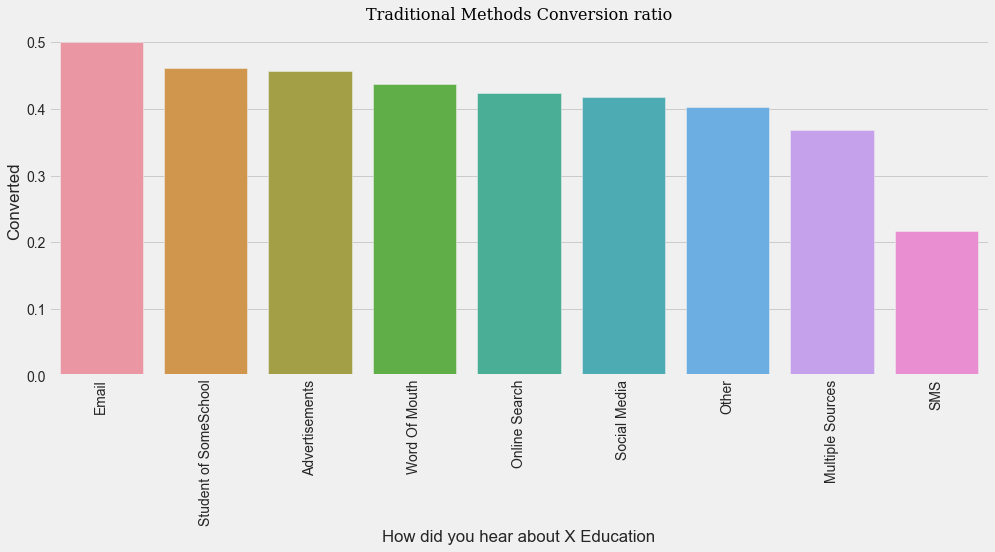

'Email Marketing seems to be one of the most influencing factor , followed by word of Mouth , Advertisments\netc. Lowest share seen by sms , although the difference in lead conversion is pretty much minimal \namong all the traditional methods'

In [38]:
data_grouped_hear_x

fig = plt.figure(figsize=(15,6))

ax = sns.barplot(data_grouped_hear_x['How did you hear about X Education'],data_grouped_hear_x['Converted'])
plt.xticks(rotation = 90)
plt.title("Traditional Methods Conversion ratio",fontdict=font)
plt.show()


'''Email Marketing seems to be one of the most influencing factor , followed by word of Mouth , Advertisments
etc. Lowest share seen by sms , although the difference in lead conversion is pretty much minimal 
among all the traditional methods'''


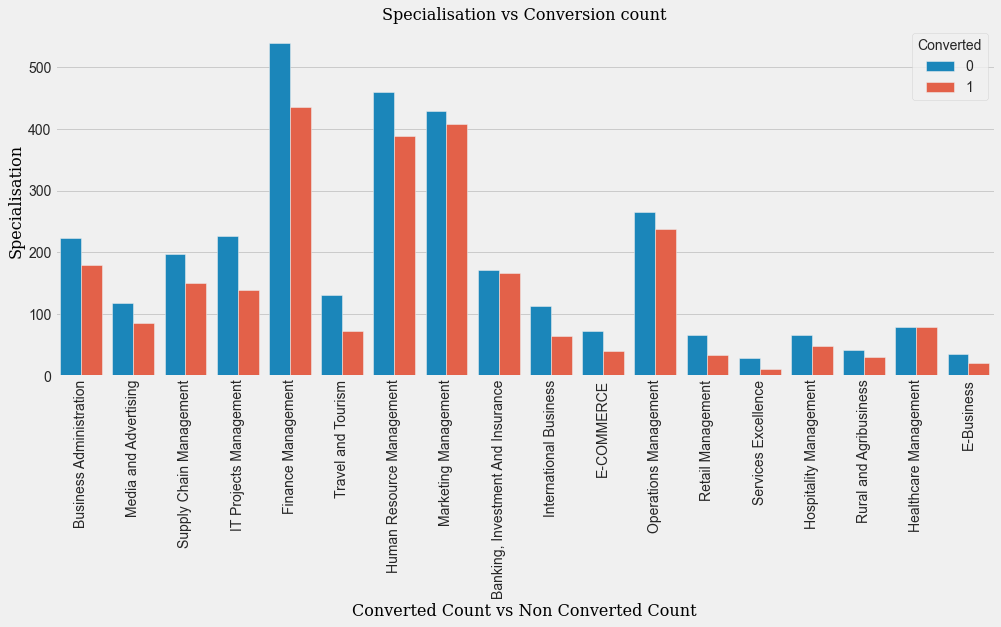

'As far as Specialisation is considered Finance Management is showing the highest conversion, but\nthere is not seem to be a significant impact of the feature specialisation on conversion , since can be\nseen that the conversion to non-conversion ratio is pretty much same for all the specialisation with respec\nto the count'

In [39]:
fig = plt.figure(figsize=(15,6))
ax = sns.countplot(data_lead_2['Specialization'] , hue=data_lead_2['Converted'])

plt.xticks(rotation = 90)
plt.xlabel('Converted Count vs Non Converted Count',fontdict=font)
plt.ylabel('Specialisation',fontdict=font)
plt.title('Specialisation vs Conversion count',fontdict=font)
plt.show()


'''As far as Specialisation is considered Finance Management is showing the highest conversion, but
there is not seem to be a significant impact of the feature specialisation on conversion , since can be
seen that the conversion to non-conversion ratio is pretty much same for all the specialisation with respec
to the count'''


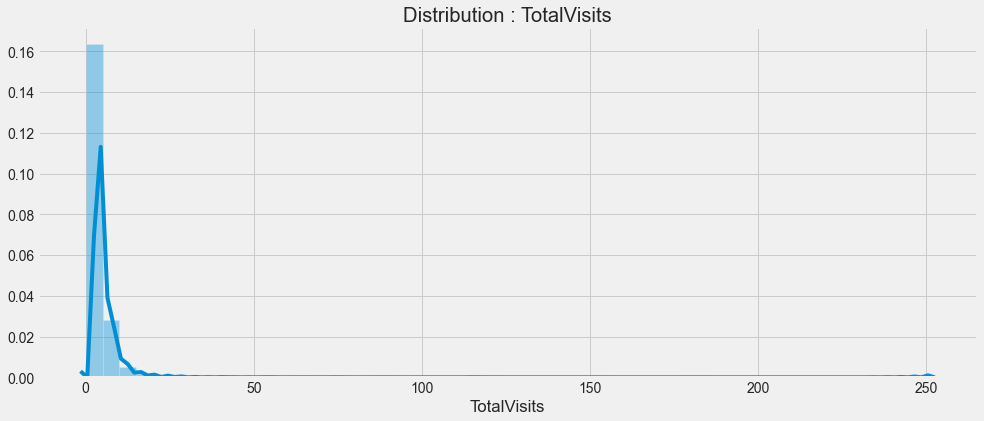

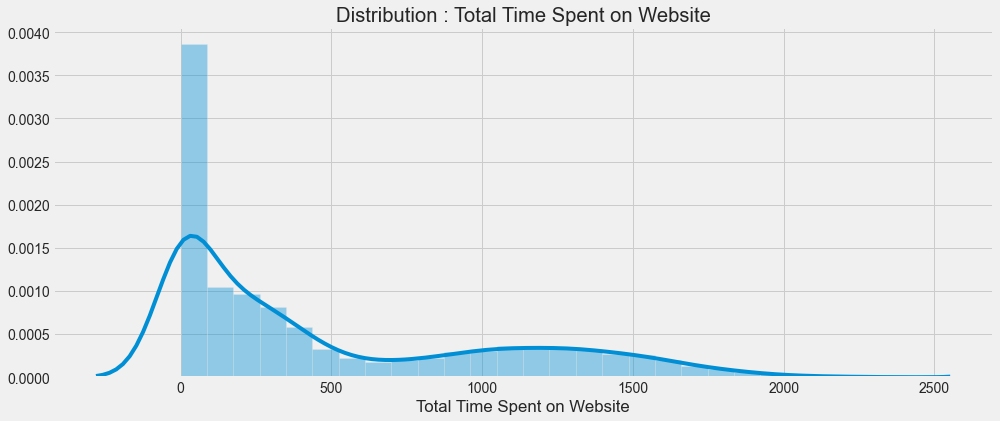

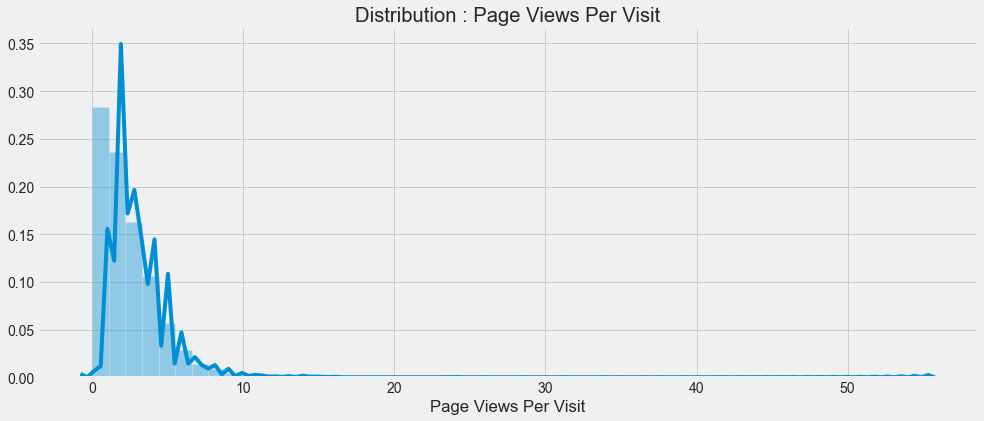

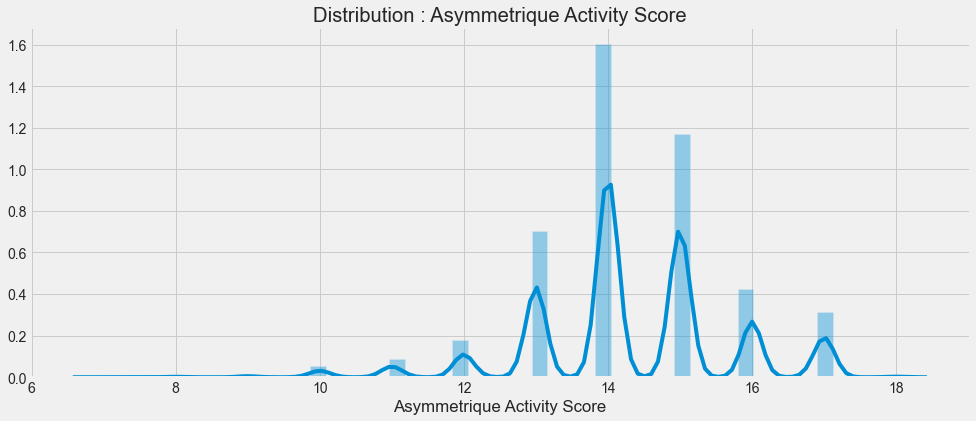

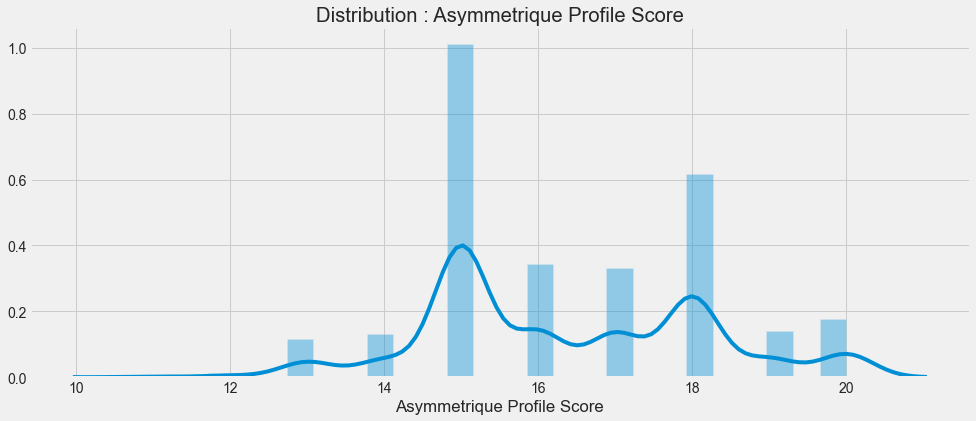

'Data Distribution regarding Asymmetrique features appears to be non continious and showing a bi-modal\ndistribution'

In [40]:
features_histogram =[features for features in data_lead_2.columns if data_lead_2[features].dtype != 'O']

features_histogram.remove('Converted')


for features in features_histogram:
    
    fig = plt.figure(figsize=(15,6))
    
    ax1 =  sns.distplot(data_lead_2[features])
    plt.title('Distribution : {}'.format(features))
    
    plt.show()
    

'''Data Distribution regarding Asymmetrique features appears to be non continious and showing a bi-modal
distribution'''

In [41]:
'''Initial Modeling'''



list_null_values_1 = []
list_null_values_2 = []


for feature in data_lead_2.columns:
    if data_lead_2[feature].isnull().sum() > 0:
        if data_lead_2[feature].isnull().sum()/len(data_lead_2) >= 0.40:
            list_null_values_1.append(feature)
        else:
            list_null_values_2.append(feature)

In [42]:


'''Lets go ahead and perform chi-square statistics. It is a good statistics measure to determine whether
the categorical(nominal variables) are showing relationship between other nominal variables. We will be using 
contingency table to create multilevel index with respect to each of our categorical variables and input
the contingency table onto the chi-square test statistics to see the result'''




def check_dependeny(feature , confidence_interval):
    
    alpha = 1 - confidence_interval
    
    
    data_lead_3 = data_lead_2.copy()
    
    data_contingency = pd.crosstab(data_lead_3[feature],data_lead_3['Converted'])
    
    stat,p,dof,expected  = stats.chi2_contingency(data_contingency)
    
    
    if p >= alpha:
        print("The feature {} is not useful".format(feature))
        
    else:
        
        print("The feature {} is useful".format(feature))
        
        
    return p
        
        

        
list_categorical = [feature for feature in data_lead_2.columns if data_lead_2[feature].dtype == 'O']

list_useful_features = []
list_not_useful_feature = []

for feature in list_categorical:
    
    p_value = check_dependeny(feature,confidence_interval=0.95)
    
    if p_value >= 0.05:
        list_not_useful_feature.append(feature)
        
    else:
        list_useful_features.append(feature)
        
        
    
    
    
            
            
            
            

    






The feature Lead Origin is useful
The feature Lead Source is useful
The feature Do Not Email is useful
The feature Do Not Call is not useful
The feature Last Activity is useful
The feature Country is useful
The feature Specialization is useful
The feature How did you hear about X Education is not useful
The feature What is your current occupation is useful
The feature What matters most to you in choosing a course is not useful
The feature Search is not useful
The feature Magazine is not useful
The feature Newspaper Article is not useful
The feature X Education Forums is not useful
The feature Newspaper is not useful
The feature Digital Advertisement is not useful
The feature Through Recommendations is not useful
The feature Receive More Updates About Our Courses is not useful
The feature Tags is useful
The feature Lead Quality is useful
The feature Update me on Supply Chain Content is not useful
The feature Get updates on DM Content is not useful
The feature Lead Profile is useful
The 

In [43]:
list_not_useful_feature

['Do Not Call',
 'How did you hear about X Education',
 'What matters most to you in choosing a course',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'City',
 'I agree to pay the amount through cheque']

In [44]:
len(list_categorical)

29

In [45]:
len(data_lead_2.columns)

35

In [46]:
# Using the Basic mean median imputation and using vif further to reduce the dimensionality



data_lead_3 = data_lead_2.copy() # creating a deep copy before any kind of imputation

In [47]:
list_null_values_1 # since we cannot remove Asymmetrique Activity Index and other scoring features lets 
# lets insert the same into list_null_2

['How did you hear about X Education',
 'Lead Quality',
 'Lead Profile',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score']

In [48]:
for element in list_null_values_1:
    if 'As' in element:
        list_null_values_2.append(element)

In [49]:
list_null_values_2 # These are the features which we will be further imputing

def immpute(feature):
    
    if data_lead_3[feature].dtype == 'O':
        
        mode_impute = data_lead_3[feature].mode()[0]
        
        data_lead_3[feature].fillna(mode_impute,inplace = True)
        
    else:
        data_lead_3[feature].fillna(data_lead_3[feature].median(),inplace = True)
        
        

In [50]:
data_lead_3['Specialization'].mode()[0]

'Finance Management'

In [51]:
for feature in list_null_values_2:
    immpute(feature)

In [52]:
data_lead_3.drop(['How did you hear about X Education','Lead Quality','Lead Profile'],axis=1,inplace=True)

In [53]:
data_lead_3.isnull().sum() # Our data is ready for further steps

Lead Origin                                      0
Lead Source                                      0
Do Not Email                                     0
Do Not Call                                      0
Converted                                        0
TotalVisits                                      0
Total Time Spent on Website                      0
Page Views Per Visit                             0
Last Activity                                    0
Country                                          0
Specialization                                   0
What is your current occupation                  0
What matters most to you in choosing a course    0
Search                                           0
Magazine                                         0
Newspaper Article                                0
X Education Forums                               0
Newspaper                                        0
Digital Advertisement                            0
Through Recommendations        

In [54]:
'''Outliers Inspction'''


features_numerical = [features for features in data_lead_3.columns if data_lead_3[features].dtype != 'O']

features_numerical.pop(0) # removing converted from the list

'Converted'

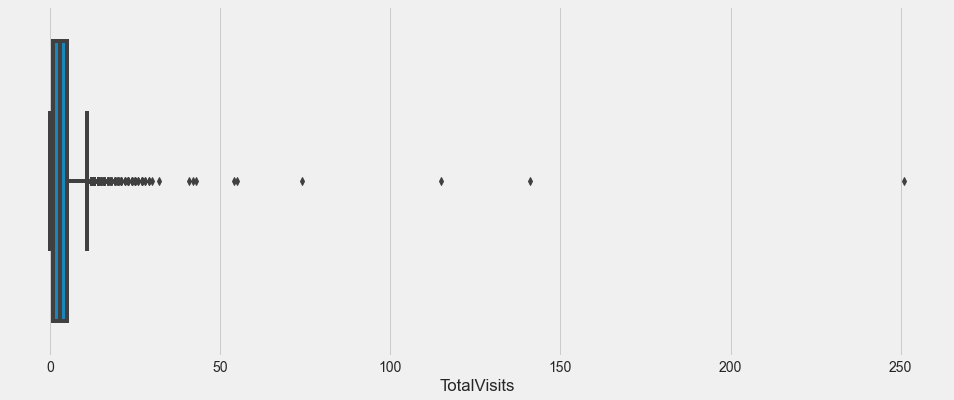

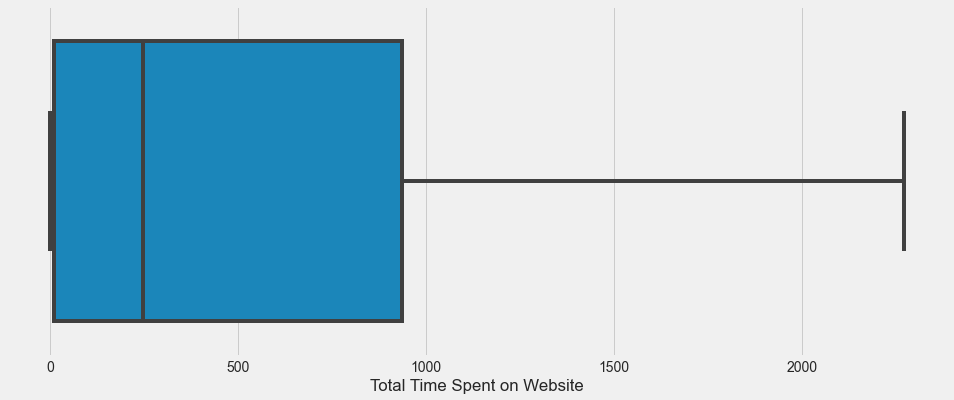

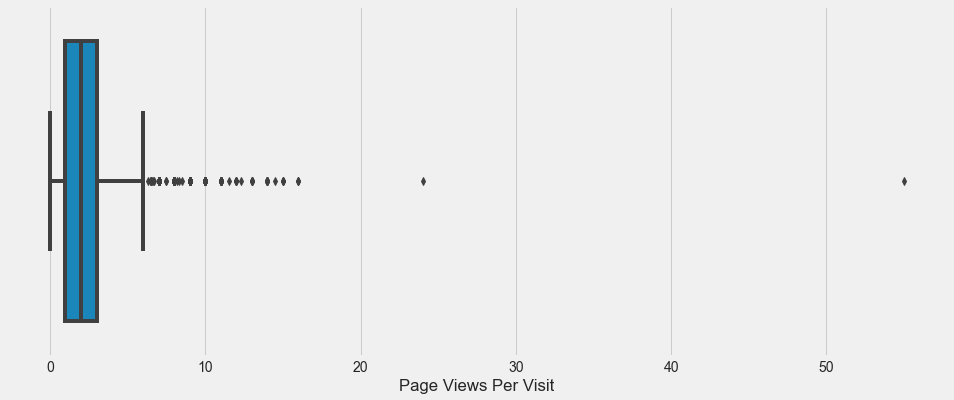

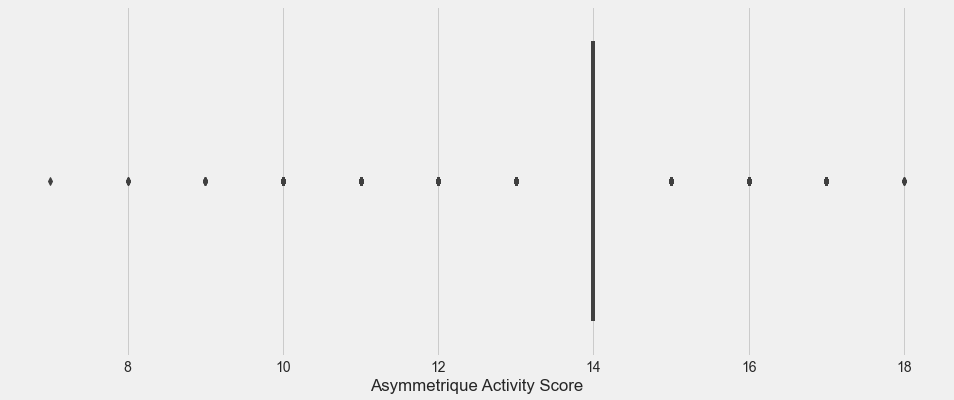

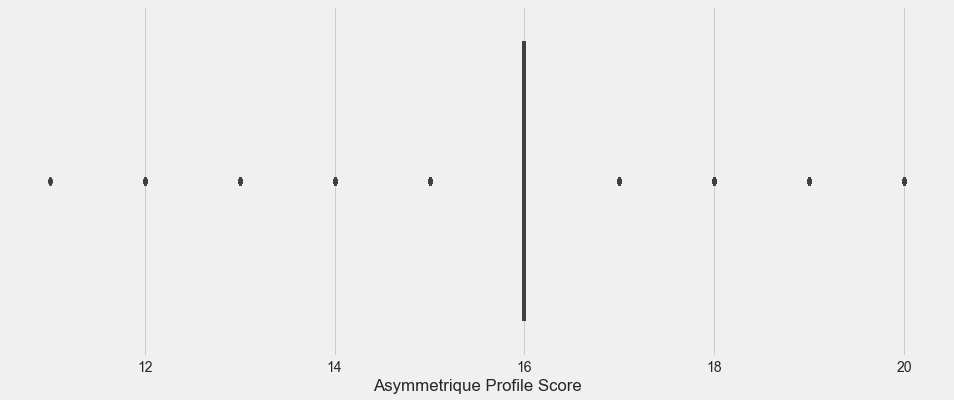

In [55]:
features_numerical

for features in features_numerical:
    
    fig = plt.figure(figsize=(15,6))
    
    ax = sns.boxplot(data_lead_3[features])
    
    plt.show()
    
    
    '''Considering only total visits , total time spent on websites ,page view as numerical variables 
    here since the profiling features are showing fixed discrete numerical values'''

In [56]:
# Outlier Inspection using the IQR Concept

def Outliers_detection(feature):
    
    data_lead_4 = data_lead_3.copy()
    
    
    Q1 = data_lead_4[feature].quantile(0.25)
    Q3 = data_lead_4[feature].quantile(0.75)
    
    IQR = Q3 - Q1
    
    m,n = data_lead_4.shape
    
    Upper_whisker = Q3 + 1.5*IQR
    lower_whisker = Q1 - 1.5*IQR
    
    data_lead_4 = data_lead_4[(data_lead_4[feature] >= lower_whisker) & (data_lead_4[feature] <= Upper_whisker)]
    
    m1,n1 = data_lead_4.shape
    
    print("The numnber of outliers removed are {} from feature {}".format(m-m1,feature))
    
    

In [57]:
features_numerical.remove('Asymmetrique Activity Score')
features_numerical.remove('Asymmetrique Profile Score')

In [58]:
for features in features_numerical:
    Outliers_detection(features)
    
'''There are total 267 outliers and 360 outliers in totalvisits where we can remove them'''

The numnber of outliers removed are 267 from feature TotalVisits
The numnber of outliers removed are 0 from feature Total Time Spent on Website
The numnber of outliers removed are 360 from feature Page Views Per Visit


'There are total 267 outliers and 360 outliers in totalvisits where we can remove them'

In [59]:
data_lead_3['Magazine'].value_counts()

'''There are certain columns in our dataset with only one category  like magazine as no which are
not adding anything to our variables'''
    
    

'There are certain columns in our dataset with only one category  like magazine as no which are\nnot adding anything to our variables'

In [60]:
'''Lets see if there are more than 1 such feature'''


features_delete = []

for features in data_lead_3.columns:
    if data_lead_3[features].nunique() < 2:
        features_delete.append(features)

In [61]:
features_delete

['Magazine',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque']

In [62]:
data_lead_3.drop(features_delete,axis=1,inplace=True)

In [63]:
def binary(x):
    if x == 'Yes':
        return 1
    else:
        return 0

In [64]:
data_lead_4 = data_lead_3.copy()

In [65]:
features_binary = data_lead_4.loc[:,'Search':'Through Recommendations'].columns.to_list()

In [66]:
data_lead_4[features_binary] = data_lead_4[features_binary].applymap(binary)

In [67]:
data_lead_4['A free copy of Mastering The Interview'] = data_lead_4['A free copy of Mastering The Interview'
                                                                   ].apply(binary)

In [68]:
data_lead_4['Do Not Call'] = data_lead_4['Do Not Call'].apply(binary)
data_lead_4['Do Not Email'] = data_lead_4['Do Not Email'].apply(binary)

In [69]:
features_categorical_dummy = [features for features in data_lead_4.columns if data_lead_4[features].
                             dtype == 'O']

In [70]:
features_categorical_dummy

data_dummies = data_lead_4[features_categorical_dummy]

In [71]:
# Importing RFE to select top 30 features for our prediction
# Following which we will be using Manual Calibration using vif score , pvalue etc to tune the model


from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [72]:
data_lead_4

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,0,0,0,0.0,0,0.00,Page Visited on Website,Other,Finance Management,Unemployed,Better Career Prospects,0,0,0,0,0,0,Interested in other courses,Mumbai,02.Medium,02.Medium,15.0,15.0,0,Modified
1,API,Organic Search,0,0,0,5.0,674,2.50,Email Opened,India,Finance Management,Unemployed,Better Career Prospects,0,0,0,0,0,0,Ringing,Mumbai,02.Medium,02.Medium,15.0,15.0,0,Email Opened
2,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.00,Email Opened,India,Business Administration,Student,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Mumbai,02.Medium,01.High,14.0,20.0,1,Email Opened
3,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.00,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,0,0,0,0,0,0,Ringing,Mumbai,02.Medium,01.High,13.0,17.0,0,Modified
4,Landing Page Submission,Google,0,0,1,2.0,1428,1.00,Converted to Lead,India,Finance Management,Unemployed,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Mumbai,02.Medium,01.High,15.0,18.0,0,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,Landing Page Submission,Direct Traffic,1,0,1,8.0,1845,2.67,Email Marked Spam,Saudi Arabia,IT Projects Management,Unemployed,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Mumbai,02.Medium,01.High,15.0,17.0,0,Email Marked Spam
9236,Landing Page Submission,Direct Traffic,0,0,0,2.0,238,2.00,SMS Sent,India,Media and Advertising,Unemployed,Better Career Prospects,0,0,0,0,0,0,wrong number given,Mumbai,02.Medium,01.High,14.0,19.0,1,SMS Sent
9237,Landing Page Submission,Direct Traffic,1,0,0,2.0,199,2.00,SMS Sent,India,Business Administration,Unemployed,Better Career Prospects,0,0,0,0,0,0,invalid number,Mumbai,02.Medium,01.High,13.0,20.0,1,SMS Sent
9238,Landing Page Submission,Google,0,0,1,3.0,499,3.00,SMS Sent,India,Human Resource Management,Unemployed,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Other Metro Cities,02.Medium,02.Medium,15.0,16.0,0,SMS Sent


In [73]:
'''For WOE we are going to use categorical variables although it can be used on continious variable given
we can bin it.'''
for feature in data_lead_4.columns:
    print("{} : {}".format(feature,data_lead_4[feature].nunique()))
    
''' From here we can see that the columns like Lead Source , and other columns we have high cardinality
many of these features have presently low weightage in terms of frequency and hence can be merged as one
single column as others '''

# creating a list of all the features where cardinality is greater than 10

list_cardinality_conversion = []

for feature in data_lead_4.columns:
    if data_lead_4[feature].dtypes == 'O' and data_lead_4[feature].nunique() > 10:
        list_cardinality_conversion.append(feature)

Lead Origin : 5
Lead Source : 20
Do Not Email : 2
Do Not Call : 2
Converted : 2
TotalVisits : 41
Total Time Spent on Website : 1731
Page Views Per Visit : 114
Last Activity : 17
Country : 9
Specialization : 18
What is your current occupation : 6
What matters most to you in choosing a course : 3
Search : 2
Newspaper Article : 2
X Education Forums : 2
Newspaper : 2
Digital Advertisement : 2
Through Recommendations : 2
Tags : 26
City : 6
Asymmetrique Activity Index : 3
Asymmetrique Profile Index : 3
Asymmetrique Activity Score : 12
Asymmetrique Profile Score : 10
A free copy of Mastering The Interview : 2
Last Notable Activity : 16


In [74]:
list_cardinality_conversion # We will be reducing the cardinality of all these features further

['Lead Source',
 'Last Activity',
 'Specialization',
 'Tags',
 'Last Notable Activity']

In [75]:
data_lead_4['Last Activity'].value_counts()/len(data_lead_4)

'''As we can see from the below that for the Last Activity  three top major categories have a share of close
to 70% of the data and rest is divided among other categories
to reduce the cardinality we will convert all these categories into one single category called
other_activity we are keeping the threshold as 1%'''

list_category = list(data_lead_4['Last Activity'].value_counts()[data_lead_4['Last Activity'].value_counts()/
                                                                len(data_lead_4) < 0.01].index)

In [76]:
data_lead_4['Last Activity'] = np.where(data_lead_4['Last Activity'].isin(list_category) , 
                                        'other_activity',data_lead_4['Last Activity'])

In [77]:
data_lead_4['Last Activity'].value_counts() # We have created a new category

Email Opened                 3540
SMS Sent                     2745
Olark Chat Conversation       973
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 326
Email Link Clicked            267
Form Submitted on Website     116
other_activity                112
Unreachable                    93
Name: Last Activity, dtype: int64

In [78]:
print(data_lead_4['Lead Source'].value_counts()/len(data_lead_4) * 100)

list_category_Lead_Source = list(data_lead_4['Lead Source'].value_counts()[data_lead_4['Lead Source'].value_counts()/
                                                                len(data_lead_4) < 0.01].index)

data_lead_4['Lead Source'] = np.where(data_lead_4['Lead Source'].isin(list_category_Lead_Source) , 
                                     'other_source' , data_lead_4['Lead Source'])

print(" ")
print(" ")
print(data_lead_4['Specialization'].value_counts()/len(data_lead_4) * 100 , end = " ")

list_category_Specialization = list(data_lead_4['Specialization'].value_counts()[data_lead_4['Specialization'].value_counts()/
                                                                len(data_lead_4) < 0.01].index)

data_lead_4['Specialization'] = np.where(data_lead_4['Specialization'].isin(list_category_Specialization)
                                        ,'other_Specialization' , data_lead_4['Specialization'])

print(" ")
print(" ")
print(data_lead_4['Tags'].value_counts()/len(data_lead_4) * 100)

list_category_tags =  list(data_lead_4['Tags'].value_counts()[data_lead_4['Tags'].value_counts()/
                                                                len(data_lead_4) < 0.01].index)

data_lead_4['Tags'] = np.where(data_lead_4['Tags'].isin(list_category_tags)
                                        ,'other_Tags' , data_lead_4['Tags'])


print(" ")
print(" ")

print(data_lead_4['Last Notable Activity'].value_counts() / len(data_lead_4) * 100)


list_Last_Notable_Activity = list(data_lead_4['Last Notable Activity'].value_counts()[data_lead_4['Last Notable Activity'].value_counts()/
                                                                len(data_lead_4) < 0.01].index)



data_lead_4['Last Notable Activity'] = np.where(data_lead_4['Last Notable Activity'].isin(list_Last_Notable_Activity)
                                        ,'other_Notable_Activity' , data_lead_4['Last Notable Activity'])




Google               31.482684
Direct Traffic       27.521645
Olark Chat           18.993506
Organic Search       12.489177
Reference             5.779221
Welingak Website      1.536797
Referral Sites        1.352814
Facebook              0.595238
bing                  0.064935
Click2call            0.043290
Live Chat             0.021645
Press_Release         0.021645
Social Media          0.021645
blog                  0.010823
WeLearn               0.010823
youtubechannel        0.010823
welearnblog_Home      0.010823
testone               0.010823
Pay per Click Ads     0.010823
NC_EDM                0.010823
Name: Lead Source, dtype: float64
 
 
Finance Management                   47.142857
Human Resource Management             9.177489
Marketing Management                  9.069264
Operations Management                 5.443723
Business Administration               4.361472
IT Projects Management                3.961039
Supply Chain Management               3.777056
Banking, Inve

In [79]:
data_lead_4['Last Notable Activity'].value_counts()

Modified                   3407
Email Opened               2827
SMS Sent                   2172
Page Visited on Website     318
Olark Chat Conversation     183
Email Link Clicked          173
other_Notable_Activity      160
Name: Last Notable Activity, dtype: int64

In [80]:
data_lead_4['Last Activity'].value_counts()

Email Opened                 3540
SMS Sent                     2745
Olark Chat Conversation       973
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 326
Email Link Clicked            267
Form Submitted on Website     116
other_activity                112
Unreachable                    93
Name: Last Activity, dtype: int64

In [81]:
data_lead_1['Last Activity'].value_counts()

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

In [82]:
data_lead_4['City'].value_counts()

Mumbai                         6891
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

In [83]:
data_lead_4

''' In our dataset data_lead_4 we have columns like Total_visits , total_time_spent on website
and Score columns which are showing discrete values , we can go ahead and try to bin them and then
apply WOE along with other categorical columns'''

' In our dataset data_lead_4 we have columns like Total_visits , total_time_spent on website\nand Score columns which are showing discrete values , we can go ahead and try to bin them and then\napply WOE along with other categorical columns'

In [84]:
'''WOE for categorical variables'''


data_lead_cross_tab_Last_Activity = pd.crosstab(data_lead_4['Last Activity'] , data_lead_4['Converted']
                                               ,margins=False)

In [85]:
data_lead_cross_tab_Last_Activity

total_converted = data_lead_4['Converted'].sum() 
'''This can be total distribution of good data'''

'This can be total distribution of good data'

In [86]:
total_converted # total summation of converted leads

3561

In [87]:
total_not_converted = len(data_lead_4) - total_converted 
'''This is the total distribution of bad data'''

'This is the total distribution of bad data'

In [88]:
data_lead_cross_tab_Last_Activity['% of good data'] = data_lead_cross_tab_Last_Activity[1]/total_converted
data_lead_cross_tab_Last_Activity['% of bad data'] = data_lead_cross_tab_Last_Activity[0]/total_not_converted

In [89]:
data_lead_cross_tab_Last_Activity['WOE'] = np.log(data_lead_cross_tab_Last_Activity['% of good data']/data_lead_cross_tab_Last_Activity['% of bad data'])

In [90]:
data_lead_cross_tab_Last_Activity

Converted,0,1,% of good data,% of bad data,WOE
Last Activity,,,,,
Converted to Lead,374,54,0.015164,0.065857,-1.468538
Email Bounced,300,26,0.007301,0.052826,-1.978952
Email Link Clicked,194,73,0.020500,0.034161,-0.510665
Email Opened,2206,1334,0.374614,0.388449,-0.036265
Form Submitted on Website,88,28,0.007863,0.015496,-0.678399
Olark Chat Conversation,889,84,0.023589,0.156542,-1.892547
Page Visited on Website,489,151,0.042404,0.086107,-0.708349
SMS Sent,1018,1727,0.484976,0.179257,0.995280
Unreachable,62,31,0.008705,0.010917,-0.226413


In [91]:
data_lead_cross_tab_Last_Activity['IV'] = (data_lead_cross_tab_Last_Activity['% of good data']
                                           - data_lead_cross_tab_Last_Activity['% of bad data']) * data_lead_cross_tab_Last_Activity['WOE']

In [92]:
print(data_lead_cross_tab_Last_Activity['IV'].sum())
''' Our code is working fine we are going to generalise into a function later'''
''' Negative WOE is the profile for the leads which are getting dead or not converted something which can
be noticed is that almost all are having negative WOE instead of sms sent. This could be a major indicator
of lead getting converted or not'''

'''Also iv value is somewhere closer to 0.76 which is a strong predictor'''

0.766160044412815


'Also iv value is somewhere closer to 0.76 which is a strong predictor'

In [93]:
def calculate_woe(feature): 
    '''This function calculates the WOE and merge into a dataframe the returned variable is 
    a dataframe'''
    
    global total_converted # making total_converted and total_not_converted as global variable
    global total_not_converted
    data_lead_4_copy = data_lead_4.copy()
    
    if feature != 'Converted' and data_lead_4[feature].dtype == 'O':
        
        data_cross_tab_1 = pd.crosstab(data_lead_4_copy[feature] , data_lead_4_copy['Converted'])
        data_cross_tab_1['% of good data'] = data_cross_tab_1[1]/total_converted
        data_cross_tab_1['% of bad data'] = data_cross_tab_1[0]/total_not_converted
        
        data_cross_tab_1['WOE'] = np.log(data_cross_tab_1['% of good data']/data_cross_tab_1['% of bad data'])
        
        data_cross_tab_1['IV'] = (data_cross_tab_1['% of good data'] - data_cross_tab_1['% of bad data']) *  data_cross_tab_1['WOE']
        
        data_cross_tab_1['WOE'].replace(np.inf , 0 , inplace = True) 
        '''There could be a possiblity of data '''
        data_cross_tab_1['IV'].replace(np.inf,0 , inplace = True)
        
        print(data_cross_tab_1['IV'].sum())
        
    
    return data_cross_tab_1
        
        
        
        
        

In [94]:
def calculate_IV(feature): # This is the same function but instead of returning a dataframe
    #we are going to append the IV value of each of the categorical column
    
    global total_converted # making total_converted and total_not_converted as global variable
    global total_not_converted
    
    
    data_lead_4_copy = data_lead_4.copy()
    
    if feature != 'Converted' and data_lead_4[feature].dtype == 'O':
        
        data_cross_tab = pd.crosstab(data_lead_4_copy[feature] , data_lead_4_copy['Converted'])
        data_cross_tab['% of good data'] = data_cross_tab[1]/total_converted
        data_cross_tab['% of bad data'] = data_cross_tab[0]/total_not_converted
        
        
        data_cross_tab['WOE'] = np.log(data_cross_tab['% of good data']/data_cross_tab['% of bad data'])
        
        data_cross_tab['IV'] = (data_cross_tab['% of good data'] - data_cross_tab['% of bad data']) *  data_cross_tab['WOE']
        
        data_cross_tab['WOE'].replace(np.inf , 0 , inplace = True) 
        '''There could be a possiblity of data '''
        data_cross_tab['IV'].replace(np.inf,0 , inplace = True)
        
    
    return data_cross_tab['IV'].sum()
        
        
      
        

In [95]:
features_categorical = [features for features in data_lead_4.columns if data_lead_4[features].dtype == 'O']

In [96]:
features_categorical


['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Country',
 'Specialization',
 'What is your current occupation',
 'What matters most to you in choosing a course',
 'Tags',
 'City',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'Last Notable Activity']

In [97]:
list_categorical_IV = []

for features in features_categorical:
    list_categorical_IV.append(calculate_IV(features))

C:\Users\lenovo\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [98]:
list_categorical_IV



[0.574056738766901,
 0.6498774258031274,
 0.766160044412815,
 0.02075595938409285,
 0.08326426574708116,
 0.5280275342425856,
 4.8887358639269664e-05,
 2.6554961203410463,
 0.011710642635192075,
 0.10936140695785253,
 0.04423493895283471,
 0.6158127240522753]

In [99]:
data_IV = pd.DataFrame()

data_IV['feature'] = features_categorical
data_IV['IV'] = list_categorical_IV

In [100]:
data_IV

'''From here c ir can be seen that tags is having highest IV values among all the predictors
which is suspiciously good but lets see how our model is getting treated with this respect'''

'From here c ir can be seen that tags is having highest IV values among all the predictors\nwhich is suspiciously good but lets see how our model is getting treated with this respect'

In [101]:
'''Calculating  IV value for Binary models'''

def calculate_woe_binary(features):
    
    data_lead_4_copy = data_lead_4.copy()
    
    
    if data_lead_4_copy[features].nunique() == 2: # taking only binary variable
        
        data_cross_tab_2 = pd.crosstab(data_lead_4_copy[features] , data_lead_4_copy['Converted'])
        
        
        data_cross_tab_2['% of good data'] = data_cross_tab_2[1]/total_converted
        data_cross_tab_2['% of bad data'] = data_cross_tab_2[0]/total_not_converted
        
        data_cross_tab_2['WOE'] = np.log(data_cross_tab_2['% of good data']/data_cross_tab_2['% of bad data'])
        
        data_cross_tab_2['IV'] = (data_cross_tab_2['% of good data'] - data_cross_tab_2['% of bad data']) *  data_cross_tab_2['WOE']
        
        data_cross_tab_2['WOE'].replace(np.inf , 0 , inplace = True) 
        '''There could be a possiblity of data '''
        data_cross_tab_2['IV'].replace(np.inf,0 , inplace = True)
        
        
        
    
    return data_cross_tab_2,data_cross_tab_2['IV'].sum()
  

    
    
    
    

In [102]:
def calculate_IV_binary(features): # This is the same function but instead of returning a dataframe
    #we are going to append the IV value of each of the categorical column
    
    
    
    data_lead_4_copy = data_lead_4.copy()
    
    if data_lead_4_copy[features].nunique() == 2:
        
        data_cross_tab = pd.crosstab(data_lead_4_copy[feature] , data_lead_4_copy['Converted'])
        data_cross_tab['% of good data'] = data_cross_tab[1]/total_converted
        data_cross_tab['% of bad data'] = data_cross_tab[0]/total_not_converted
        
        
        data_cross_tab['WOE'] = np.log(data_cross_tab['% of good data']/data_cross_tab['% of bad data'])
        
        data_cross_tab['IV'] = (data_cross_tab['% of good data'] - data_cross_tab['% of bad data']) *  data_cross_tab['WOE']
        
        data_cross_tab['WOE'].replace(np.inf , 0 , inplace = True) 
        '''There could be a possiblity of data '''
        data_cross_tab['IV'].replace(np.inf,0 , inplace = True)
        
    
    return data_cross_tab['IV'].sum()

In [103]:
features_binary = [features for features in data_lead_4.columns if data_lead_4[features].nunique() == 2]

In [104]:
features_binary

['Do Not Email',
 'Do Not Call',
 'Converted',
 'Search',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'A free copy of Mastering The Interview']

In [105]:
list_IV_value_binary = []
for features in features_binary:
    list_IV_value_binary.append(calculate_IV_binary(features))
    

In [106]:
list_IV_value_binary

[0.6158127240522753,
 0.6158127240522753,
 0.6158127240522753,
 0.6158127240522753,
 0.6158127240522753,
 0.6158127240522753,
 0.6158127240522753,
 0.6158127240522753,
 0.6158127240522753,
 0.6158127240522753]

In [107]:
data_binary_iv = pd.DataFrame()

data_binary_iv['feature'] = features_binary
data_binary_iv['IV'] = list_IV_value_binary

In [108]:
data_binary_iv

,feature,IV
0,Do Not Email,0.615813
1,Do Not Call,0.615813
2,Converted,0.615813
3,Search,0.615813
4,Newspaper Article,0.615813
5,X Education Forums,0.615813
6,Newspaper,0.615813
7,Digital Advertisement,0.615813
8,Through Recommendations,0.615813
9,A free copy of Mastering The Interview,0.615813


In [109]:
data_categorical = pd.concat([data_IV, data_binary_iv])

In [110]:
data_categorical

'''Lets create a new column callled important and not important based on the IV value'''

data_categorical['Importance'] = data_categorical['IV'].apply(lambda x: 'not important' if x <= 0.02 else 'important')

In [111]:
data_categorical
'''We have 2 features what matters and city and should not be used further for building the model'''

'We have 2 features what matters and city and should not be used further for building the model'

In [112]:
data_categorical

,feature,IV,Importance
0,Lead Origin,0.574057,important
1,Lead Source,0.649877,important
2,Last Activity,0.766160,important
3,Country,0.020756,important
4,Specialization,0.083264,important
5,What is your current occupation,0.528028,important
6,What matters most to you in choosing a course,0.000049,not important
7,Tags,2.655496,important
8,City,0.011711,not important
9,Asymmetrique Activity Index,0.109361,important


In [113]:
'''Asymmetric Profile index , etc are all the columns which are taken after qualifying the leads and hence
should not be included'''

feature_Asymmetrique = [feature for feature in data_lead_4.columns if 'Asymmetrique' in feature]

In [114]:
feature_Asymmetrique

data_lead_6 = data_lead_4.copy()

data_lead_6.drop(feature_Asymmetrique , axis = 1 , inplace = True)

In [115]:
''' We also have features like What matters and city which is showing low feature importance or 
a low predictive power based on the IV value'''
data_lead_6.drop(['What matters most to you in choosing a course','City'] , axis=1 , inplace=True)

In [116]:
data_lead_6


dummy_variables = [feature for feature in data_lead_6.columns if data_lead_6[feature].dtypes == 'O']

In [117]:
dummy_frame = pd.get_dummies(data_lead_6[dummy_variables] , drop_first= True)

In [118]:
dummy_frame

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Lead Source_other_source,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_other_activity,Country_India,Country_Other,Country_Qatar,Country_Saudi Arabia,Country_Singapore,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Specialization_Business Administration,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_other_Specialization,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Ringing,Tags_Will revert after reading the email,Tags_other_Tags,Tags_switched off,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_other_Notable_Activity
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
9236,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9237,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9238,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [119]:
data_lead_6


data_lead_concat_2 = pd.concat([data_lead_6,dummy_frame] , axis=1)

In [120]:
data_lead_concat_2.drop(dummy_variables,axis=1, inplace=True)

In [121]:
data_lead_concat_2

,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Lead Source_other_source,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_other_activity,Country_India,Country_Other,Country_Qatar,Country_Saudi Arabia,Country_Singapore,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Specialization_Business Administration,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_other_Specialization,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Ringing,Tags_Will revert after reading the email,Tags_other_Tags,Tags_switched off,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_other_Notable_Activity
0,0,0,0,0.0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,5.0,674,2.50,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,1,2.0,1532,2.00,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0,0,0,1.0,305,1.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0,0,1,2.0,1428,1.00,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,1,0,1,8.0,1845,2.67,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
9236,0,0,0,2.0,238,2.00,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9237,1,0,0,2.0,199,2.00,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9238,0,0,1,3.0,499,3.00,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

In [122]:

X1 = data_lead_concat_2.drop('Converted' , axis = 1)
y1= data_lead_concat_2[['Converted']]

In [123]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X1, y1, test_size=0.33, random_state=100)

In [124]:
Standard_Scaler_2 = StandardScaler()

In [125]:
list_standarize_2 = [feature for feature in data_lead_concat_2.columns if data_lead_concat_2[feature].nunique() > 2]

In [126]:
X_train_2[list_standarize_2] = Standard_Scaler_2.fit_transform(X_train_2[list_standarize_2])

<ipython-input-126-32c713c532ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_2[list_standarize_2] = Standard_Scaler_2.fit_transform(X_train_2[list_standarize_2])
C:\Users\lenovo\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [127]:
X_train_2

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Lead Source_other_source,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_other_activity,Country_India,Country_Other,Country_Qatar,Country_Saudi Arabia,Country_Singapore,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Specialization_Business Administration,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_other_Specialization,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Ringing,Tags_Will revert after reading the email,Tags_other_Tags,Tags_switched off,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_other_Notable_Activity
8741,0,0,0.290008,0.154344,0.078746,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
6337,0,0,-0.275216,-0.006739,-0.163364,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
475,0,0,-0.652032,-0.885373,-1.131805,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2096,0,0,0.666825,1.640700,2.257739,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7953,0,0,0.101600,0.600983,0.805077,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,0,0,-0.652032,-0.885373,-1.131805,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
79,0,0,-0.086808,0.405121,-0.163364,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
8039,0,0,-0.652032,-0.885373,-1.131805,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
6936,0,0,-0.275216,-0.449717,-

In [128]:
from sklearn.feature_selection import RFE
log_reg_lead_2= LogisticRegression()
rfe_1 = RFE(log_reg_lead_2, 30)             # running RFE with 30 variables as output
rfe_1 = rfe_1.fit(X_train_2, y_train_2)

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _ch

In [129]:
cols_use_1 = (X_train_2.columns[rfe_1.support_])

In [130]:
cols_use_1



Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Source_Welingak Website', 'Last Activity_Email Opened',
       'Last Activity_SMS Sent', 'Last Activity_other_activity',
       'Country_Other', 'Country_Qatar', 'Country_Saudi Arabia',
       'Specialization_Finance Management',
       'Specialization_Hospitality Management',
       'What is your current occupation_Housewife',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional', 'Tags_Busy',
       'Tags_Closed by Horizzon', 'Tags_Graduation in progress',
       'Tags_Interested  in full time MBA', 'Tags_Interested in other courses',
       'Tags_Lost to EINS', 'Tags_Not doing further education', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_switched off',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation',
     

In [131]:
X_train_3 = X_train_2[list(cols_use_1)]


In [132]:

X_train_3_sm  = sm.add_constant(X_train_3)

In [133]:
X_train_3_sm

,const,Do Not Email,Total Time Spent on Website,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Source_Welingak Website,Last Activity_Email Opened,Last Activity_SMS Sent,Last Activity_other_activity,Country_Other,Country_Qatar,Country_Saudi Arabia,Specialization_Finance Management,Specialization_Hospitality Management,What is your current occupation_Housewife,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Ringing,Tags_Will revert after reading the email,Tags_switched off,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_SMS Sent,Last Notable Activity_other_Notable_Activity
8741,1.0,0,0.154344,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6337,1.0,0,-0.006739,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
475,1.0,0,-0.885373,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2096,1.0,0,1.640700,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7953,1.0,0,0.600983,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,1.0,0,-0.885373,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
79,1.0,0,0.405121,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
8039,1.0,0,-0.885373,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6936,1.0,0,-0.449717,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [134]:
logm_lead_2 = sm.GLM(y_train_2,X_train_3_sm, family = sm.families.Binomial())
res_2 = logm_lead_2.fit()
print(res_2.summary())

'''There are some columns having null values'''

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6159
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 08 Feb 2021   Deviance:                          nan
Time:                        03:43:56   Pearson chi2:                 1.30e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:946: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:947: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:945: RuntimeWarning: invalid value encountered in add
  return (special.gammaln(n + 1) - special.gammaln(y + 1) -


'There are some columns having null values'

In [135]:
'''vif values of the dataframe'''
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_3_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_3_sm.values, i) for i in range(X_train_3_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

''' As seen from below vif is under control we do not need any more features reduction'''


                                             Features    VIF
0                                               const  64.99
29                     Last Notable Activity_SMS Sent   5.47
7                              Last Activity_SMS Sent   4.35
16  What is your current occupation_Working Profes...   4.28
15         What is your current occupation_Unemployed   4.22
25           Tags_Will revert after reading the email   3.50
6                          Last Activity_Email Opened   2.43
27                     Last Notable Activity_Modified   2.38
24                                       Tags_Ringing   2.33
3                 Lead Origin_Landing Page Submission   2.27
9                                       Country_Other   2.11
4                           Lead Origin_Lead Add Form   1.86
12                  Specialization_Finance Management   1.78
18                            Tags_Closed by Horizzon   1.67
21                   Tags_Interested in other courses   1.64
30       Last Notable Ac

' As seen from below vif is under control we do not need any more features reduction'

In [136]:
y_train_pred_2 = res_2.predict(X_train_3_sm)

In [137]:
y_train_pred_2_dataframe = pd.DataFrame()

y_train_pred_2_dataframe['y_train_predicted_probability'] = y_train_pred_2

In [138]:
y_train_pred_2_dataframe['y_train'] = y_train_2

In [139]:
y_train_pred_2_dataframe

,y_train_predicted_probability,y_train
8741,0.056902,0
6337,0.017866,0
475,0.999138,1
2096,0.668929,1
7953,0.923767,1
...,...,...
350,0.883590,1
79,0.987669,1
8039,0.283058,1
6936,0.018652,0


In [140]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_2_dataframe[i]= y_train_pred_2_dataframe.y_train_predicted_probability.map(lambda x: 1 if x > i else 0)
y_train_pred_2_dataframe.head()

'''From a brief glance something as expected can be seen that '''

'From a brief glance something as expected can be seen that '

     prob  accuracy     sensi     speci
0.0   0.0  0.380129  1.000000  0.000000
0.1   0.1  0.782391  0.968551  0.668230
0.2   0.2  0.839903  0.945601  0.775085
0.3   0.3  0.888207  0.894178  0.884545
0.4   0.4  0.902100  0.869103  0.922335
0.5   0.5  0.899838  0.837229  0.938233
0.6   0.6  0.896769  0.807480  0.951525
0.7   0.7  0.884653  0.758606  0.961949
0.8   0.8  0.852827  0.640884  0.982799
0.9   0.9  0.819225  0.539312  0.990878


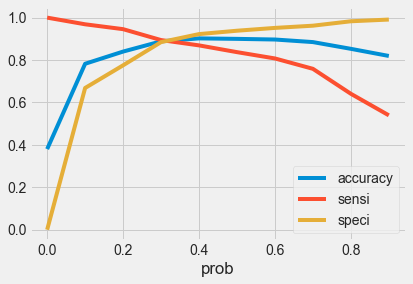

'A good balance score is looking somewhere close to a probability of 0.3'

In [141]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_2_dataframe.y_train, y_train_pred_2_dataframe[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

'''From cutoff_df it can be clearlu'''

cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

'''A good balance score is looking somewhere close to a probability of 0.3'''

In [142]:
y_train_pred_2_dataframe['final_predicted'] = y_train_pred_2_dataframe.y_train_predicted_probability.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_2_dataframe.head()

,y_train_predicted_probability,y_train,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
8741,0.056902,0,1,0,0,0,0,0,0,0,0,0,0
6337,0.017866,0,1,0,0,0,0,0,0,0,0,0,0
475,0.999138,1,1,1,1,1,1,1,1,1,1,1,1
2096,0.668929,1,1,1,1,1,1,1,1,0,0,0,1
7953,0.923767,1,1,1,1,1,1,1,1,1,1,1,1


In [143]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score

In [144]:
precision_score(y_train_pred_2_dataframe.y_train, y_train_pred_2_dataframe.final_predicted)

'''Our model is showing a precision of 0.8 as of now'''

'Our model is showing a precision of 0.8 as of now'

In [145]:
accuracy_score(y_train_pred_2_dataframe.y_train, y_train_pred_2_dataframe.final_predicted)

0.8882067851373182

In [146]:
'''Lets go ahead and check the recall rate'''

recall_score(y_train_pred_2_dataframe.y_train, y_train_pred_2_dataframe.final_predicted)

'''Our recall or true positive stands somewhere close to 0.9 which can be refered as 90% of our data is 
predicted correctly in terms of lead getting converted'''



'Our recall or true positive stands somewhere close to 0.9 which can be refered as 90% of our data is \npredicted correctly in terms of lead getting converted'

In [147]:
from sklearn import metrics

In [148]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [149]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_2_dataframe.y_train, y_train_pred_2_dataframe.y_train_predicted_probability, drop_intermediate = False )

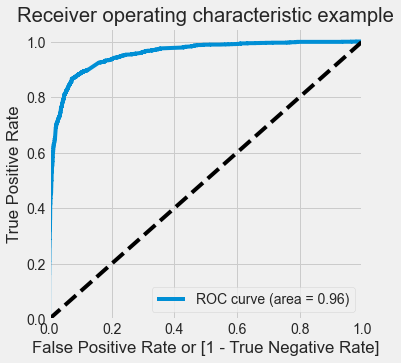

'Our ROC curve looks good'

In [150]:
draw_roc(y_train_pred_2_dataframe.y_train, y_train_pred_2_dataframe.y_train_predicted_probability)

'''Our ROC curve looks good'''

In [151]:
'''Lets go ahead and train our model on testing data_set'''

X_test_2[list_standarize_2] = Standard_Scaler_2.transform(X_test_2[list_standarize_2])

<ipython-input-151-05da58fc5f0e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_2[list_standarize_2] = Standard_Scaler_2.transform(X_test_2[list_standarize_2])
C:\Users\lenovo\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [152]:
X_test_2

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Lead Source_other_source,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_other_activity,Country_India,Country_Other,Country_Qatar,Country_Saudi Arabia,Country_Singapore,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Specialization_Business Administration,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_other_Specialization,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Ringing,Tags_Will revert after reading the email,Tags_other_Tags,Tags_switched off,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_other_Notable_Activity
4269,0,0,0.855233,0.965250,2.741959,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2376,0,0,-0.652032,-0.885373,-1.131805,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
7766,0,0,0.290008,-0.777374,1.289298,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
9199,0,0,-0.652032,-0.885373,-1.131805,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4359,0,0,-0.652032,-0.885373,-1.131805,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8924,0,0,-0.463624,-0.114738,-0.647584,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2601,1,0,-0.086808,3.172818,-0.163364,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
7180,0,0,-0.652032,-0.885373,-1.131805,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3141,0,0,-0.652032,-0.

In [153]:
X_test_2_selected = X_test_2[list(cols_use_1)]

In [154]:
X_test_2_selected_sm = sm.add_constant(X_test_2_selected)

In [155]:
X_test_2_selected_sm

,const,Do Not Email,Total Time Spent on Website,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Source_Welingak Website,Last Activity_Email Opened,Last Activity_SMS Sent,Last Activity_other_activity,Country_Other,Country_Qatar,Country_Saudi Arabia,Specialization_Finance Management,Specialization_Hospitality Management,What is your current occupation_Housewife,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Ringing,Tags_Will revert after reading the email,Tags_switched off,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_SMS Sent,Last Notable Activity_other_Notable_Activity
4269,1.0,0,0.965250,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2376,1.0,0,-0.885373,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
7766,1.0,0,-0.777374,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
9199,1.0,0,-0.885373,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4359,1.0,0,-0.885373,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8924,1.0,0,-0.114738,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2601,1.0,1,3.172818,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
7180,1.0,0,-0.885373,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3141,1.0,0,-0.885373,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [156]:
y_test_2_pred = res_2.predict(X_test_2_selected_sm)

In [157]:
y_test_2_pred

4269    0.947052
2376    0.974617
7766    0.950887
9199    0.002333
4359    0.883590
          ...   
8924    0.001851
2601    0.790288
7180    0.283058
3141    0.137745
1006    0.314271
Length: 3050, dtype: float64

In [158]:
y_test_2_pred

4269    0.947052
2376    0.974617
7766    0.950887
9199    0.002333
4359    0.883590
          ...   
8924    0.001851
2601    0.790288
7180    0.283058
3141    0.137745
1006    0.314271
Length: 3050, dtype: float64

In [159]:
y_test_dataframe = pd.DataFrame()

y_test_dataframe['y_test'] = y_test_2['Converted']
y_test_dataframe['y_test_probability'] = y_test_2_pred

In [160]:
y_test_dataframe['y_test_final'] = y_test_dataframe.y_test_probability.apply(lambda x : 1 if x > 0.3 else 0)

In [161]:
y_test_dataframe

,y_test,y_test_probability,y_test_final
4269,1,0.947052,1
2376,1,0.974617,1
7766,1,0.950887,1
9199,0,0.002333,0
4359,1,0.883590,1
...,...,...,...
8924,0,0.001851,0
2601,1,0.790288,1
7180,0,0.283058,0
3141,0,0.137745,0


In [162]:
print(precision_score(y_test_dataframe.y_test, y_test_dataframe.y_test_final))



0.8293620292083013


In [163]:
print(accuracy_score(y_test_dataframe.y_test, y_test_dataframe.y_test_final))

'''Our Accuracy score looks good enough also we have a balanced bias and variance trade off'''

0.8849180327868853


'Our Accuracy score looks good enough also we have a balanced bias and variance trade off'

In [164]:
Prospect_ID = data_lead_1['Prospect ID'].to_list()
Lead_Number = data_lead_1['Lead Number'].to_list()


In [165]:
def create_lead_scorecard():
    global list_standarize_2 # making the following lists global so that they can be used anywhere 
    #inside the function
    global cols_use_1
    global Prospect_ID
    global Lead_Number
    
    
    data_concat = data_lead_concat_2.copy()
    data_final_merge = data_lead_4.copy()
    
    X_concat = data_lead_concat_2.drop('Converted' , axis = 1)
    
    X_concat[list_standarize_2] = Standard_Scaler_2.transform(X_concat[list_standarize_2])
    
    X_cols_concat_use = X_concat[cols_use_1]
    
    X_cols_concat_use_sm = sm.add_constant(X_cols_concat_use)
    
    
    y_predicted_probability = res_2.predict(X_cols_concat_use_sm)
    
    
    data_final_merge['y_predicted_Probability'] = y_predicted_probability
    
    data_final_merge['Prospect_ID'] = Prospect_ID
    
    data_final_merge['Lead_ID'] = Lead_Number
    
    
    
    '''We are going to get the score by multiplying the number with 100 and later converting
    it into int type to get discrete  integer values'''
    data_final_merge['Lead_Score'] = data_final_merge['y_predicted_Probability'] * 100
    
    data_final_merge['Lead_Score'] = data_final_merge['Lead_Score'].astype('int')
    
    
    
    return data_final_merge
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

In [166]:
data_score = create_lead_scorecard()

In [167]:
data_score

'''Lets create a seprate dataframe which consists of only Lead_ID , Prospect_id and lead score assigned'''


data_score_card_leads = data_score[['Lead_ID','Prospect_ID','Lead_Score']]

In [168]:
data_score

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Last Notable Activity,y_predicted_Probability,Prospect_ID,Lead_ID,Lead_Score
0,API,Olark Chat,0,0,0,0.0,0,0.00,Page Visited on Website,Other,Finance Management,Unemployed,Better Career Prospects,0,0,0,0,0,0,Interested in other courses,Mumbai,02.Medium,02.Medium,15.0,15.0,0,Modified,0.002467,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,0
1,API,Organic Search,0,0,0,5.0,674,2.50,Email Opened,India,Finance Management,Unemployed,Better Career Prospects,0,0,0,0,0,0,Ringing,Mumbai,02.Medium,02.Medium,15.0,15.0,0,Email Opened,0.007571,2a272436-5132-4136-86fa-dcc88c88f482,660728,0
2,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.00,Email Opened,India,Business Administration,Student,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Mumbai,02.Medium,01.High,14.0,20.0,1,Email Opened,0.952823,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,95
3,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.00,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,0,0,0,0,0,0,Ringing,Mumbai,02.Medium,01.High,13.0,17.0,0,Modified,0.000758,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,0
4,Landing Page Submission,Google,0,0,1,2.0,1428,1.00,Converted to Lead,India,Finance Management,Unemployed,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Mumbai,02.Medium,01.High,15.0,18.0,0,Modified,0.323904,3256f628-e534-4826-9d63-4a8b88782852,660681,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,Landing Page Submission,Direct Traffic,1,0,1,8.0,1845,2.67,other_activity,Saudi Arabia,IT Projects Management,Unemployed,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Mumbai,02.Medium,01.High,15.0,17.0,0,other_Notable_Activity,0.701179,19d6451e-fcd6-407c-b83b-48e1af805ea9,579564,70
9236,Landing Page Submission,Direct Traffic,0,0,0,2.0,238,2.00,SMS Sent,India,Media and Advertising,Unemployed,Better Career Prospects,0,0,0,0,0,0,other_Tags,Mumbai,02.Medium,01.High,14.0,19.0,1,SMS Sent,0.096879,82a7005b-7196-4d56-95ce-a79f937a158d,579546,9
9237,Landing Page Submission,Direct Traffic,1,0,0,2.0,199,2.00,SMS Sent,India,Business Administration,Unemployed,Better Career Prospects,0,0,0,0,0,0,other_Tags,Mumbai,02.Medium,01.High,13.0,20.0,1,SMS Sent,0.025322,aac550fe-a586-452d-8d3c-f1b62c94e02c,579545,2
9238,Landing Page Submission,Google,0,0,1,3.0,499,3.00,SMS Sent,India,Human Resource Management,Unemployed,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Other Metro Cities,02.Medium,02.Medium,15.0,16.0,0,SMS Sent,0.864895,5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9,579538,86


In [169]:
lead_score = data_score[['Prospect_ID','Lead_ID','Lead_Score']]

In [170]:
print(lead_score) 
'''Below is the final dataset'''

                               Prospect_ID  Lead_ID  Lead_Score
0     7927b2df-8bba-4d29-b9a2-b6e0beafe620   660737           0
1     2a272436-5132-4136-86fa-dcc88c88f482   660728           0
2     8cc8c611-a219-4f35-ad23-fdfd2656bd8a   660727          95
3     0cc2df48-7cf4-4e39-9de9-19797f9b38cc   660719           0
4     3256f628-e534-4826-9d63-4a8b88782852   660681          32
...                                    ...      ...         ...
9235  19d6451e-fcd6-407c-b83b-48e1af805ea9   579564          70
9236  82a7005b-7196-4d56-95ce-a79f937a158d   579546           9
9237  aac550fe-a586-452d-8d3c-f1b62c94e02c   579545           2
9238  5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9   579538          86
9239  571b5c8e-a5b2-4d57-8574-f2ffb06fdeff   579533          79

[9240 rows x 3 columns]


'Below is the final dataset'